# Initialize

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
from IPython.display import display, Math
from matplotlib.ticker import StrMethodFormatter, PercentFormatter
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import shift
from scipy.constants import c, pi
from pandas import DataFrame

import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.backend.operators import compute_velocity, compute_position, compute_objective_function
from pyswarms.backend.handlers import VelocityHandler, BoundaryHandler

from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

import sys
sys.path.append('../../python')

from Functions import *
from Classes import *

versions = ['v202','v221','v231','v242']  # Lumerical versions in this scope

try:
    print('imp module found!')
    import imp
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py')
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')

except:
    print('imp module not found. Trying with importlib...')
    from importlib.machinery import SourceFileLoader
    print('found!')
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py').load_module()
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')

from lumapi import LumApiError

plt.rcParams["figure.figsize"] = (8,6) 
plt.rc('font', size=12)

imp module found!
version v202 found!


C:\Users\Caio\AppData\Local\Temp\ipykernel_22824\3940450298.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [43]:
# inter = lumapi.INTERCONNECT(filename='../../../simulation/files/pnn/AnalysisPNN.icp')
inter = lumapi.INTERCONNECT()

# MZI Ideal Cell Test

Specific tests for unique circuits based on Ideal MZI Cell model. Includes:
- Gain and angle in function of $\theta_1$, with $\theta_2$ locked
- Splitter 1:4 using 3 MZI Cells (amplitude and angle analysis)

In [7]:
inter.switchtolayout()
inter.deleteall()
inter.addelement('MZI Ideal Cell')
inter.set('x position',0)
inter.set('y position',300)
inter.addelement('Optical Network Analyzer')
inter.set('number of input ports',3)

inter.connect('ONA_1','output','IDEAL_CELL_1','port 1')
inter.connect('ONA_1','input 1','IDEAL_CELL_1','port 3')
inter.connect('ONA_1','input 2','IDEAL_CELL_1','port 4')
inter.connect('ONA_1','input 3','IDEAL_CELL_1','port 2')

1.0

  0%|          | 0/60 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '../Media/Ideal MZI Cell/Gain x Theta1.png'

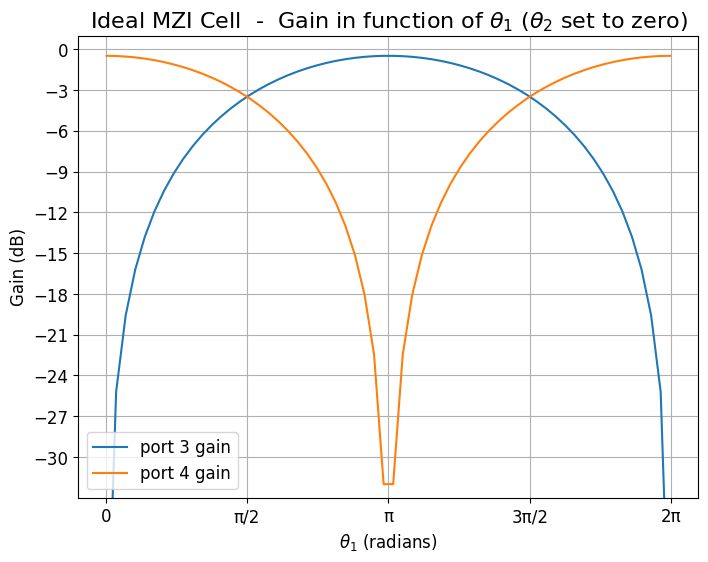

In [45]:
Theta1Array = np.linspace(0.01,2*pi-0.01,60)

progress = tqdm(total= len(Theta1Array))

Port1Gain = np.zeros(len(Theta1Array))
Port2Gain = np.zeros(len(Theta1Array))
Port1Angle = np.zeros(len(Theta1Array))
Port2Angle = np.zeros(len(Theta1Array))

inter.setnamed('IDEAL_CELL_1','WvgLoss',588.88)

for i in range(len(Theta1Array)):
    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_1','Theta 1',Theta1Array[i])
    inter.run()

    Port1Gain[i] = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)'][0]
    Port2Gain[i] = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)'][0]
    Port1Angle[i] = inter.getresult('ONA_1','input 1/mode 1/angle')['TE angle (rad)'][0]
    Port2Angle[i] = inter.getresult('ONA_1','input 2/mode 1/angle')['TE angle (rad)'][0]

    progress.update(1)

plt.figure(figsize=(8,6))
plt.plot(Theta1Array,Port1Gain,label='port 3 gain')
plt.plot(Theta1Array,Port2Gain,label='port 4 gain')
plt.xlabel('$θ_1$ (radians)',fontsize=12)
plt.ylabel('Gain (dB)',fontsize=12)
plt.title('Ideal MZI Cell  -  Gain in function of $θ_1$ ($θ_2$ set to zero)',fontsize=16)
dxArray = {'0':0 , 'π/2':pi/2 , 'π':pi, '3π/2':3*pi/2, '2π':2*pi}
plt.xticks(list(dxArray.values()), labels=dxArray.keys())
dyArray = [0,-3,-6,-9,-12,-15,-18,-21,-24,-27,-30]
plt.yticks(dyArray)
plt.ylim(-33,1)
plt.legend()
plt.grid()

datapath = '../Media/Ideal MZI Cell'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Gain x Theta1" + ".png", transparent=False, facecolor="white", bbox_inches="tight")


plt.figure(figsize=(8,6))
plt.plot(Theta1Array,Port1Angle,label='port 3 angle')
plt.plot(Theta1Array,Port2Angle,'--',label='port 4 angle')
plt.xlabel('$θ_1$ (radians)',fontsize=12)
plt.ylabel('Angle (rad)',fontsize=12)
plt.title('Ideal MZI Cell  -  Angle in function of $θ_1$ ($θ_2$ set to zero)',fontsize=16)
dxArray = {'0':0, 'π/2':pi/2 , 'π':pi, '3π/2':3*pi/2, '2π':2*pi}
plt.xticks(list(dxArray.values()), labels=dxArray.keys())
dyArray = {'-π':-pi , '-π/2':-pi/2, '0':0, 'π/2':pi/2, 'π':pi}
plt.yticks(list(dyArray.values()), labels=dyArray.keys())
plt.xlim(0,pi)
plt.legend()
plt.grid()

datapath = '../Media/Ideal MZI Cell'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Angle x Theta1" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

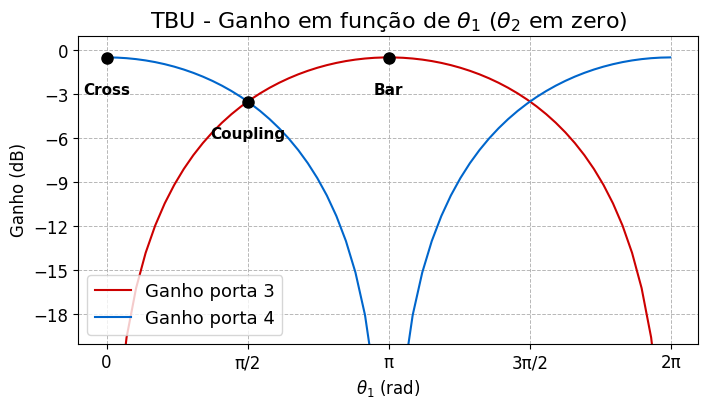

In [49]:
plt.figure(figsize=(8,4))
plt.plot(Theta1Array,Port1Gain,label='Ganho porta 3', color="#CC0000")
plt.plot(Theta1Array,Port2Gain,label='Ganho porta 4',color='#0066CC')
plt.xlabel('$θ_1$ (rad)',fontsize=12)
plt.ylabel('Ganho (dB)',fontsize=12)
plt.title('TBU - Ganho em função de $θ_1$ ($θ_2$ em zero)',fontsize=16)
dxArray = {'0':0 , 'π/2':pi/2 , 'π':pi, '3π/2':3*pi/2, '2π':2*pi}
plt.xticks(list(dxArray.values()), labels=dxArray.keys())
dyArray = [0,-3,-6,-9,-12,-15,-18,-21,-24,-27,-30]
plt.yticks(dyArray)
plt.ylim(-20,1)
plt.legend(fontsize=13)
plt.grid(which='major', linestyle='--', linewidth=0.7, alpha=0.9)

plt.plot(0, -0.52, 'o', color='black',markersize=8)
plt.plot(np.pi/2, -3.52, 'o', color='black',markersize=8)
plt.plot(np.pi, -0.52, 'o', color='black',markersize=8)

plt.text(0, -3, f'Cross', color='black', ha='center', fontsize=11,fontweight='bold')
plt.text(np.pi/2, -6, f'Coupling', color='black', ha='center', fontsize=11,fontweight='bold')
plt.text(np.pi, -3, f'Bar', color='black', ha='center', fontsize=11,fontweight='bold')


plt.savefig("TBUCELL.pdf", format="pdf")

In [ ]:
Theta1Array = np.linspace(0.01,2*pi-0.01,30)

progress = tqdm(total= len(Theta1Array))

Port1Gain = np.zeros(len(Theta1Array))
Port2Gain = np.zeros(len(Theta1Array))
Port1Angle = np.zeros(len(Theta1Array))
Port2Angle = np.zeros(len(Theta1Array))

for i in range(len(Theta1Array)):
    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_1','Theta 1',Theta1Array[i])
    inter.run()

    Port1Gain[i] = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)'][0]
    Port2Gain[i] = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)'][0]

    progress.update(1)

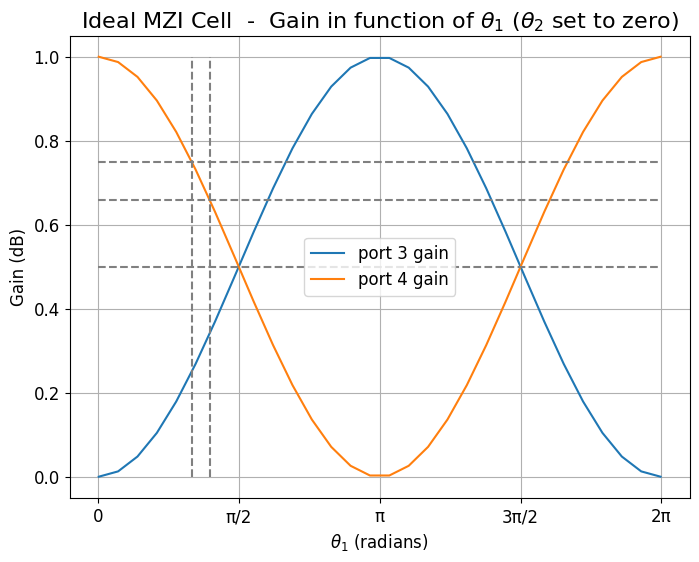

In [153]:
plt.figure(figsize=(8,6))
plt.plot(Theta1Array,10**(Port1Gain/10),label='port 3 gain')
plt.plot(Theta1Array,10**(Port2Gain/10),label='port 4 gain')
plt.xlabel('$θ_1$ (radians)',fontsize=12)
plt.ylabel('Gain (dB)',fontsize=12)
plt.title('Ideal MZI Cell  -  Gain in function of $θ_1$ ($θ_2$ set to zero)',fontsize=16)
dxArray = {'0':0 , 'π/2':pi/2 , 'π':pi, '3π/2':3*pi/2, '2π':2*pi}
plt.xticks(list(dxArray.values()), labels=dxArray.keys())
plt.hlines(0.75,xmin=0,xmax=2*pi,color='gray',linestyles='--')
plt.hlines(0.66,xmin=0,xmax=2*pi,color='gray',linestyles='--')
plt.hlines(0.5,xmin=0,xmax=2*pi,color='gray',linestyles='--')
plt.vlines(1.33*pi/4,ymin=0,ymax=1,color='gray',linestyles='--')
plt.vlines(1.585*pi/4,ymin=0,ymax=1,color='gray',linestyles='--')
plt.legend()
plt.grid()

## MZI Splitter 1:4

![MZI Splitter 1:4](../../../data/Media/UMZI_Schemetics/MZM_Splitter_1x4.png)

In [8]:
WvArray = np.linspace(1535,1560,1000)

inter.switchtolayout()
inter.deleteall()

inter.addelement('MZI Ideal Cell')
inter.set('x position',-300)
inter.set('y position',-300)
inter.addelement('MZI Ideal Cell')
inter.set('x position',0)
inter.set('y position',-400)
inter.addelement('MZI Ideal Cell')
inter.set('x position',0)
inter.set('y position',-200)

inter.addelement('Optical Network Analyzer')
inter.set('x position',-400)
inter.set('y position',-500)
inter.set('number of input ports',4)

inter.addelement('Termination Mirror')
inter.set('x position',-500)
inter.set('y position',-200)
inter.flipelement('TERM_1')
inter.addelement('Termination Mirror')
inter.set('x position',-200)
inter.set('y position',-100)
inter.flipelement('TERM_2')
inter.addelement('Termination Mirror')
inter.set('x position',-200)
inter.set('y position',-500)
inter.flipelement('TERM_3')

inter.connect('ONA_1','output','IDEAL_CELL_1','port 1')
inter.connect('ONA_1','input 1','IDEAL_CELL_2','port 3')
inter.connect('ONA_1','input 2','IDEAL_CELL_2','port 4')
inter.connect('ONA_1','input 3','IDEAL_CELL_3','port 3')
inter.connect('ONA_1','input 4','IDEAL_CELL_3','port 4')

inter.connect('IDEAL_CELL_1','port 3','IDEAL_CELL_2','port 2')
inter.connect('IDEAL_CELL_1','port 4','IDEAL_CELL_3','port 1')

inter.connect('TERM_1','port','IDEAL_CELL_1','port 2')
inter.connect('TERM_2','port','IDEAL_CELL_3','port 2')
inter.connect('TERM_3','port','IDEAL_CELL_2','port 1')

inter.setnamed('IDEAL_CELL_1','Theta 1',pi/2)
inter.setnamed('IDEAL_CELL_2','Theta 1',pi/2)
inter.setnamed('IDEAL_CELL_3','Theta 1',pi/2)

inter.setnamed('ONA_1','input parameter','start and stop')
inter.setnamed('ONA_1','start frequency',WvArray[0]*1e-9)
inter.setnamed('ONA_1','stop frequency',WvArray[-1]*1e-9)

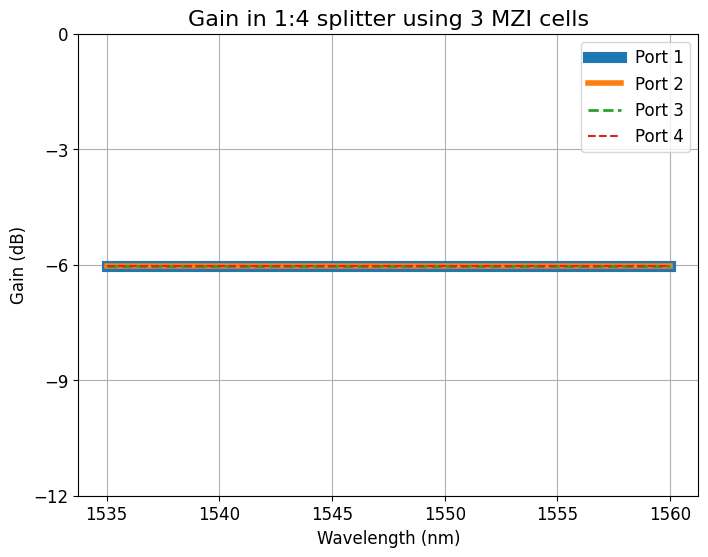

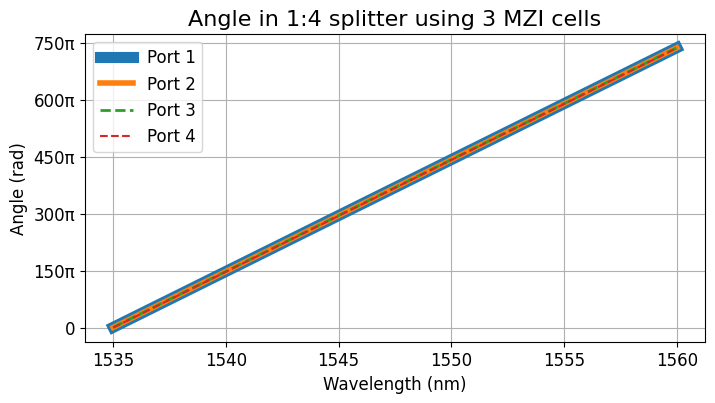

In [180]:
inter.switchtolayout()
inter.run()

Port1Gain = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
Port2Gain = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
Port3Gain = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
Port4Gain = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

Port1Angle = inter.getresult('ONA_1','input 1/mode 1/angle')['TE angle (rad)']
Port2Angle = inter.getresult('ONA_1','input 2/mode 1/angle')['TE angle (rad)']
Port3Angle = inter.getresult('ONA_1','input 3/mode 1/angle')['TE angle (rad)']
Port4Angle = inter.getresult('ONA_1','input 4/mode 1/angle')['TE angle (rad)']

plt.figure(figsize=(8,6))
plt.plot(WvArray,Port1Gain,'-',linewidth=8, label='Port 1')
plt.plot(WvArray,Port2Gain,'-',linewidth=4, label='Port 2')
plt.plot(WvArray,Port3Gain,'--',linewidth=2, label='Port 3')
plt.plot(WvArray,Port4Gain,'--', label='Port 4')
dyArray = [0,-3,-6,-9,-12]
plt.xlabel('Wavelength (nm)',fontsize=12)
plt.ylabel('Gain (dB)',fontsize=12)
plt.title('Gain in 1:4 splitter using 3 MZI cells',fontsize=16)
plt.yticks(dyArray)
plt.legend()
plt.grid()

datapath = '../Media/Ideal MZI Cell'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"1x4 splitter - Gain x Wavelength" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

plt.figure(figsize=(8,4))
plt.plot(WvArray,Port1Angle,'-',linewidth=8, label='Port 1')
plt.plot(WvArray,Port2Angle,'-',linewidth=4, label='Port 2')
plt.plot(WvArray,Port3Angle,'--',linewidth=2, label='Port 3')
plt.plot(WvArray,Port4Angle,'--', label='Port 4')
dyArray = {'0':0 , '150π':150*pi , '300π':300*pi, '450π':450*pi, '600π':600*pi, '750π':750*pi}
plt.yticks(list(dyArray.values()), labels=dyArray.keys())
plt.xlabel('Wavelength (nm)',fontsize=12)
plt.ylabel('Angle (rad)',fontsize=12)
plt.title('Angle in 1:4 splitter using 3 MZI cells',fontsize=16)
plt.legend()
plt.grid()

datapath = '../Media/Ideal MZI Cell'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"1x4 splitter - Angle x Wavelength" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

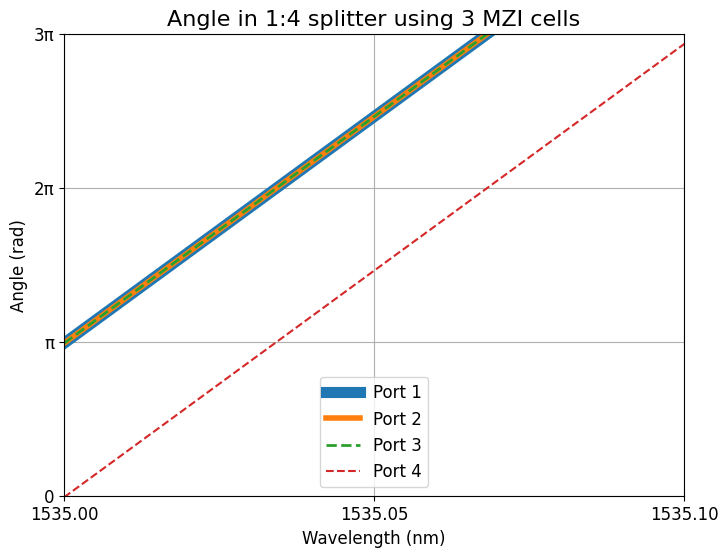

In [181]:
plt.figure(figsize=(8,6))
plt.plot(WvArray,Port1Angle,'-',linewidth=8, label='Port 1')
plt.plot(WvArray,Port2Angle,'-',linewidth=4, label='Port 2')
plt.plot(WvArray,Port3Angle,'--',linewidth=2, label='Port 3')
plt.plot(WvArray,Port4Angle,'--', label='Port 4')
dyArray = {'0':0 , 'π':pi , '2π':2*pi, '3π':3*pi}
plt.yticks(list(dyArray.values()), labels=dyArray.keys())
plt.xlabel('Wavelength (nm)',fontsize=12)
plt.ylabel('Angle (rad)',fontsize=12)
plt.title('Angle in 1:4 splitter using 3 MZI cells',fontsize=16)
dxArray = {'1535.00':1535 , '1535.05':1535.05 , '1535.10':1535.1}
plt.xticks(list(dxArray.values()), labels=dxArray.keys())
plt.ylim(0,3*pi)
plt.xlim(1535,1535+0.1)
plt.legend(loc='lower center')
plt.grid()

# Delay lines + Input Fiber (4 Taps)

First simulations of a Photonic Neural Network (PNN) using 4 taps

**First section: Parallel Photonic Neural Network**
- Disconnected arms. Delay visualization: comparison of outputs without insertion loss
- Intererence visualization: adding outputs together. Also testing with:
    - Arms C and D blocked
    - Arms A and B blocked
- XOR implementation between two sequential bits. Testing with:
    - XOR with optical fiber analysis. 10 Gbps model without insertion loss. Arms C and D blocked
    - XOR with article model (50 ps) at 20 Gbps. Analysis without insertion loss (Arms C and D blocked) and with insertion loss (All arms used)
    - Photodiode analysis (Incompleted)
- Particle Swarm Algorithm Analysis. Including:
    - Algorithm for Threshold and Sampling position optimization
    - Cornfield Vector Application
    - Algorithm applied on the PNN
    - BER x SNR analysis with Paralization analysis:
        - Agent parallel simulation
        - Power Spectral Density parallel simulation

**Second section: Series Photonic Neural Network:**
- Disconnected arms. Delay visualization: comparison of outputs without insertion loss

## Mount PNN | Parallel

In [8]:
ParallelPNN = PNN(DelayUnitLen=811e-6, unitsNextTap=2)
ParallelPNN.transmission(FiberLen=10e3)
ParallelPNN.simulation(bitrate=16e9,numofSamples=8192*2)
ParallelPNN.output(OutputType='disconnected')
ParallelPNN.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 2 | Wvg Loss: 0 dB/m
transmission :: Fiber length: 10.0 km | PRBS Type: PRBS | Pulse Amplitude: 1 | Rise/Fall Period: 0.05/0.05 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 16.0 Gbits/s | Number of Samples: 16384 | Time Window: 5.12e-09 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: disabled
AWGN post PD: disabled
Optical Filter: disabled
Output Type: disconnected


In [7]:
ParallelPNN.mount(inter)

In [264]:
ParallelPNN.update(inter)

### Delay Visualization

Disconnected arms. Delay visualization: comparison of outputs without insertion loss

In [265]:
inter.run()

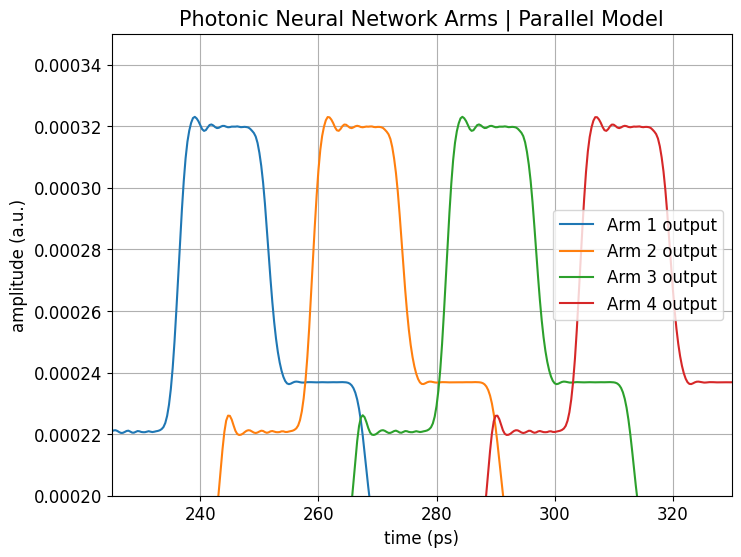

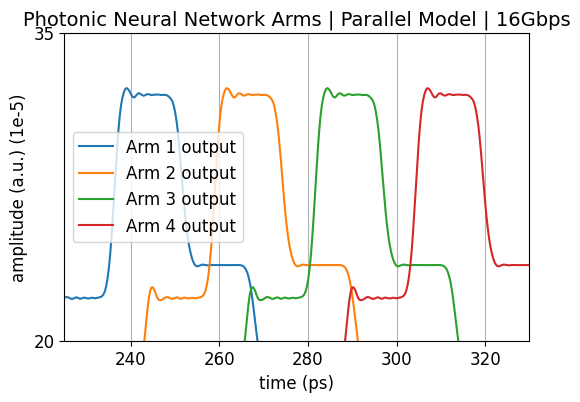

In [274]:
Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_Out2 = inter.getresult('OSC_3','signal')['amplitude (a.u.)']
Osci_Out3 = inter.getresult('OSC_4','signal')['amplitude (a.u.)']
Osci_Out4 = inter.getresult('OSC_5','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.plot(Osci_time*1e12,Osci_Out3,label='Arm 3 output')
plt.plot(Osci_time*1e12,Osci_Out4,label='Arm 4 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network Arms | Parallel Model',fontsize=15)
plt.ylim(0.0002,0.00035)
plt.xlim(225,330)
plt.legend()
plt.grid()

plt.figure(figsize=(6,4))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.plot(Osci_time*1e12,Osci_Out3,label='Arm 3 output')
plt.plot(Osci_time*1e12,Osci_Out4,label='Arm 4 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.) (1e-5)',fontsize=12)
plt.title('Photonic Neural Network Arms | Parallel Model | 16Gbps',fontsize=14)
plt.ylim(0.0002,0.00035)
plt.xlim(225,330)
dyArray = {'20':20e-5 , '35':35e-5}
plt.yticks(list(dyArray.values()), labels=dyArray.keys())
plt.legend()
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/16Gbps'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_uncombined_dL4" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

### Interference Visualization

Intererence visualization: adding outputs together. Also testing with:
- Arms C and D blocked
- Arms A and B blocked


In [3]:
ParallelPNN = PNN(DelayUnitLen=811e-6,unitsNextTap=2)
ParallelPNN.transmission(FiberLen=0,PulseAmp=2,PRBSType='codeword',MZMILoss=0)
ParallelPNN.simulation(bitrate=16e9)
ParallelPNN.output(OutputType='disconnected')
ParallelPNN.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 2 | Wvg Loss: 0 dB/m
transmission :: Fiber length: 0.0 km | PRBS Type: codeword | Pulse Amplitude: 2 | Rise/Fall Period: 0.05/0.05 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 16.0 Gbits/s | Number of Samples: 8192 | Time Window: 5.12e-09 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: disabled
AWGN post PD: disabled
Optical Filter: disabled
Output Type: disconnected


In [4]:
ParallelPNN.mount(inter)

In [282]:
ParallelPNN.update(inter)

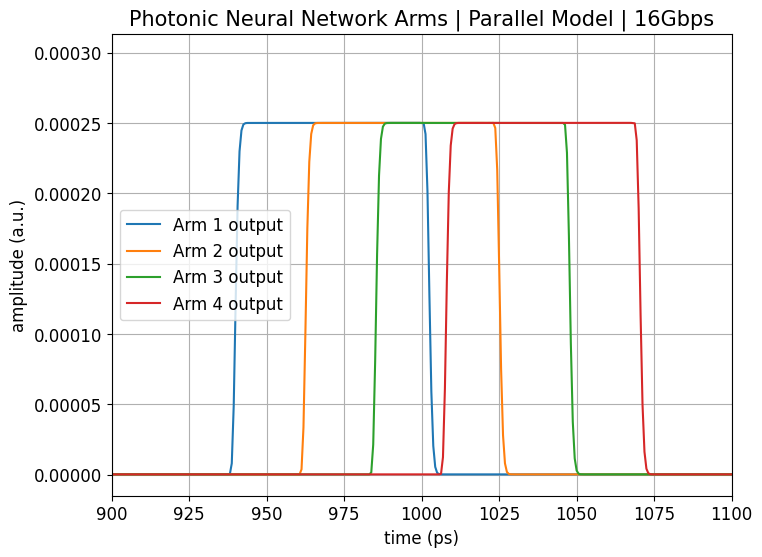

In [287]:
inter.switchtolayout()
inter.setnamed('PRBS','codeword','111101111')
inter.run()

Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_Out2 = inter.getresult('OSC_3','signal')['amplitude (a.u.)']
Osci_Out3 = inter.getresult('OSC_4','signal')['amplitude (a.u.)']
Osci_Out4 = inter.getresult('OSC_5','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.plot(Osci_time*1e12,Osci_Out3,label='Arm 3 output')
plt.plot(Osci_time*1e12,Osci_Out4,label='Arm 4 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network Arms | Parallel Model | 16Gbps',fontsize=15)
# plt.ylim(5e-5,6.7e-5)
plt.xlim(900,1100)
plt.legend()
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/16Gbps'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_uncombined_dL2_noFiber" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

In [153]:
k = 500
print(f'{Osci_Out1[k]} | {Osci_Out2[k]} | {Osci_Out3[k]} | {Osci_Out4[k]}')

5.360992593444569e-05 | 5.360992594128363e-05 | 5.360992594128377e-05 | 5.360992595383281e-05


In [9]:
ParallelPNN = PNN(DelayUnitLen=811e-6, unitsNextTap=2)
ParallelPNN.transmission(FiberLen=0,PulseAmp=2,PRBSType='alternate',MZMILoss=0)
ParallelPNN.simulation(bitrate=10e9)
ParallelPNN.output(OutputType='connected')
ParallelPNN.showParameters()
ParallelPNN.mount(inter)

general :: Model: parallel | Taps: 4 | Delay Unit Length: 0.000811 m | Units for next tap: 2
transmission :: Fiber length: 0.0 km | PRBS Type: alternate | Pulse Amplitude: 2 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 10.0 Gbits/s | Number of Samples: 8192 | Time Window: 5.12e-09 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: disabled
Output Type: connected


In [ ]:
inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Theta 1',0)
inter.setnamed('IDEAL_CELL_5','Theta 2',0)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)

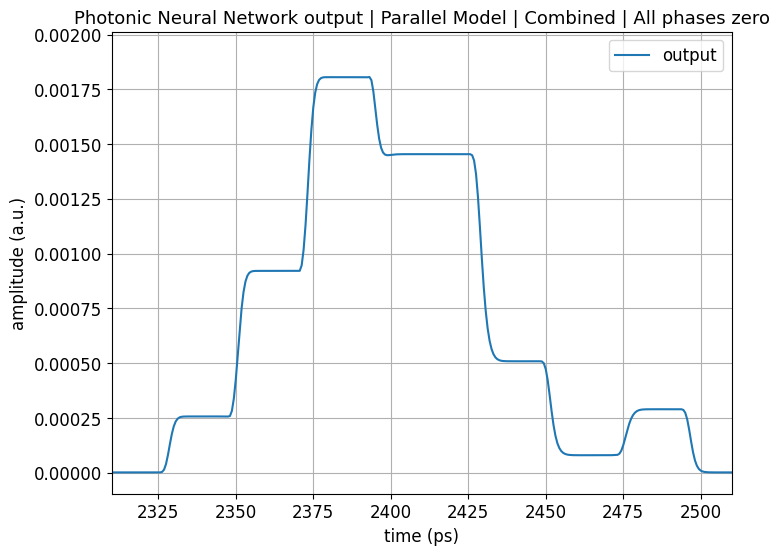

In [22]:
inter.switchtolayout()
inter.run()

Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network output | Parallel Model | Combined | All phases zero',fontsize=13)
# plt.ylim(3e-4,3.8e-4)
plt.xlim(2310,2510)
plt.legend()
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_dL2" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

#### Arms C and D blocked

<IPython.core.display.Math object>

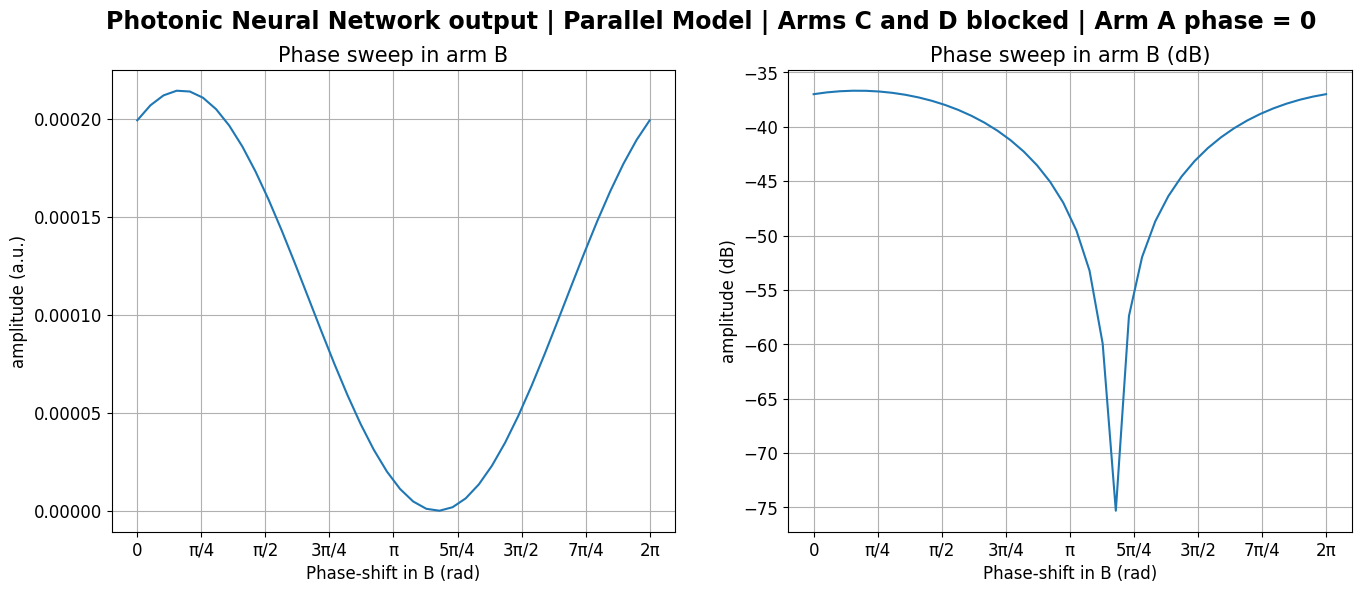

In [ ]:
PhaseArray = np.linspace(0,2*np.pi,40)
OutPt = np.zeros(len(PhaseArray))

progress = tqdm(total= len(PhaseArray))

for i in range(len(PhaseArray)):

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_5','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_5','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
    inter.run()

    OutPt[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][500]

    progress.update(1)

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle('Photonic Neural Network output | Parallel Model | Arms C and D blocked | Arm A phase = 0',fontsize=17, fontweight="bold")
dxArray = {'0':0 , 'π/4':pi/4 , 'π/2':pi/2 , '3π/4':3*pi/4 , 'π':pi, '5π/4':5*pi/4, '3π/2':3*pi/2, '7π/4':7*pi/4, '2π':2*pi}

ax[0].plot(PhaseArray,OutPt)
ax[0].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[0].set_xlabel('Phase-shift in B (rad)',fontsize=12)
ax[0].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[0].set_title('Phase sweep in arm B',fontsize=15)
ax[0].grid()

ax[1].plot(PhaseArray,10*np.log10(OutPt))
ax[1].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[1].set_xlabel('Phase-shift in B (rad)',fontsize=12)
ax[1].set_ylabel('amplitude (dB)',fontsize=12)
ax[1].set_title('Phase sweep in arm B (dB)',fontsize=15)
ax[1].grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_dL4_C&D_Blocked_B_Sweep" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

display(Math('Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPt*1e8),PhaseArray[int(np.argmin(OutPt))]/np.pi )))

# max on 0.556 rad

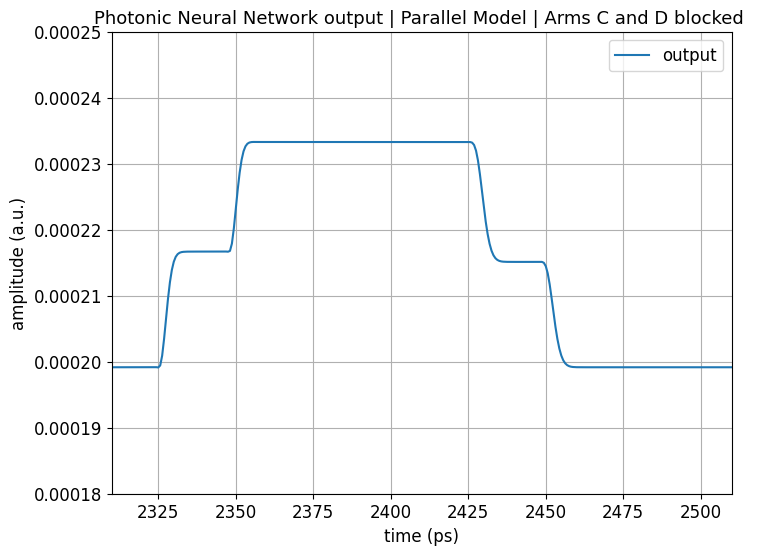

In [ ]:
inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Theta 1',0)
inter.setnamed('IDEAL_CELL_5','Theta 2',0)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)

inter.run()

Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network output | Parallel Model | Arms C and D blocked ',fontsize=13)
plt.ylim(180e-6,250e-6)
plt.xlim(2310,2510)
plt.legend()
plt.grid()

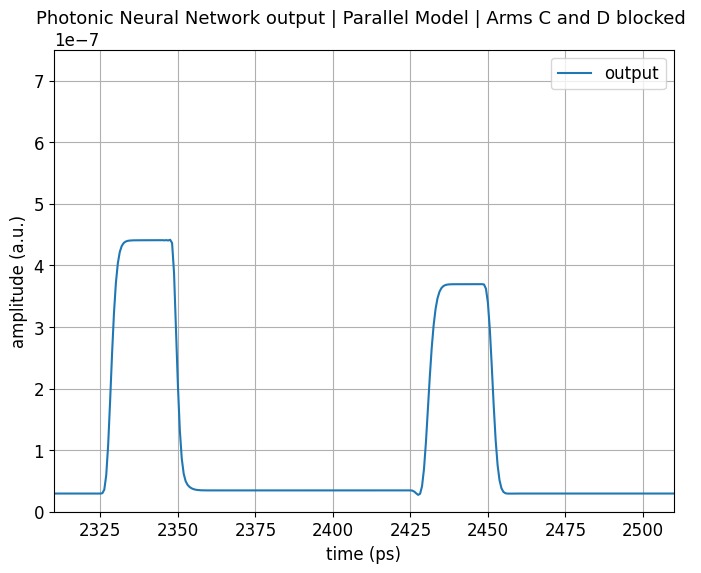

In [40]:
inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Theta 1',1.17949 * np.pi)
inter.setnamed('IDEAL_CELL_5','Theta 2',1.17949 * np.pi)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)

inter.run()

Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network output | Parallel Model | Arms C and D blocked ',fontsize=13)
plt.ylim(0e-6,0.75e-6)
plt.xlim(2310,2510)
plt.legend()
plt.grid()

In [134]:
A = np.sqrt(6.279e-5)
B = np.sqrt(5.361e-5)
print((A-B)**2)

3.6255949048169397e-07


In [26]:
A = np.sqrt(25e-5)
B = np.sqrt(25e-5)
print((A+B)**2)

0.0009999999999999998


#### Arms A and B blocked

<IPython.core.display.Math object>

<IPython.core.display.Math object>

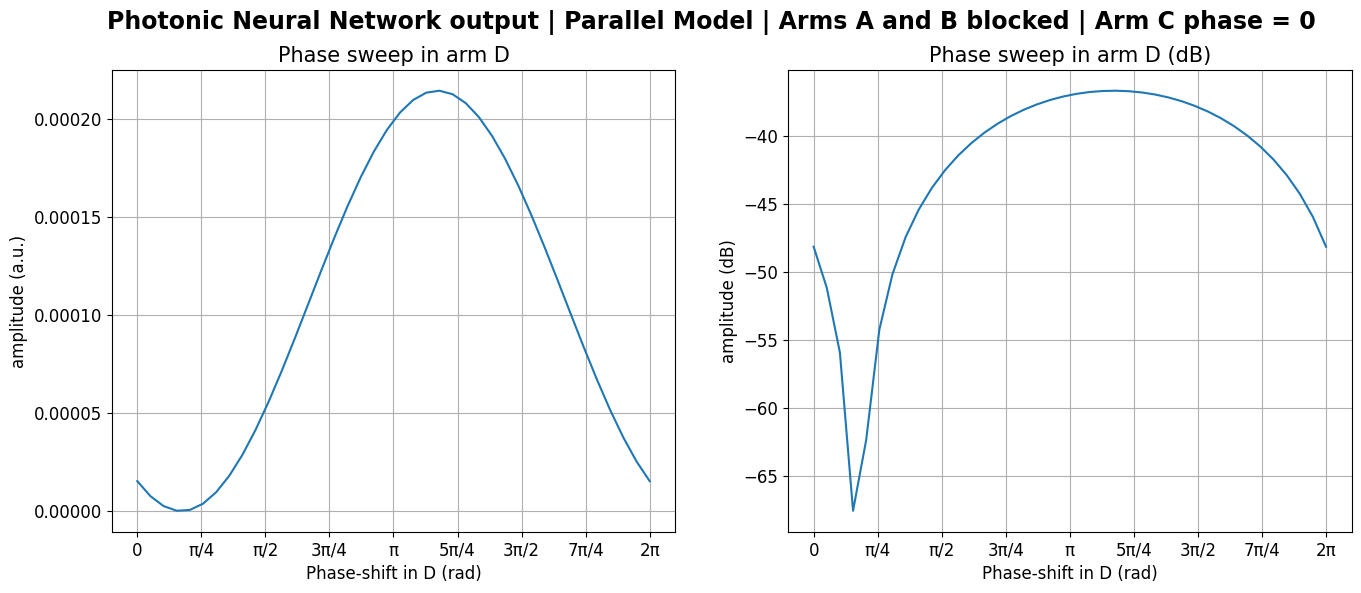

In [ ]:
PhaseArray = np.linspace(0,2*np.pi,40)
OutPt = np.zeros(len(PhaseArray))

progress = tqdm(total= len(PhaseArray))

for i in range(len(PhaseArray)):

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_7','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_7','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_4','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_5','Theta 2',np.pi)
    inter.run()

    OutPt[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][500]

    progress.update(1)

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle('Photonic Neural Network output | Parallel Model | Arms A and B blocked | Arm C phase = 0',fontsize=17, fontweight="bold")
dxArray = {'0':0 , 'π/4':pi/4 , 'π/2':pi/2 , '3π/4':3*pi/4 , 'π':pi, '5π/4':5*pi/4, '3π/2':3*pi/2, '7π/4':7*pi/4, '2π':2*pi}

ax[0].plot(PhaseArray,OutPt)
ax[0].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[0].set_xlabel('Phase-shift in D (rad)',fontsize=12)
ax[0].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[0].set_title('Phase sweep in arm D',fontsize=15)
ax[0].grid()

ax[1].plot(PhaseArray,10*np.log10(OutPt))
ax[1].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[1].set_xlabel('Phase-shift in D (rad)',fontsize=12)
ax[1].set_ylabel('amplitude (dB)',fontsize=12)
ax[1].set_title('Phase sweep in arm D (dB)',fontsize=15)
ax[1].grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_dL4_A&B_Blocked_D_Sweep" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

display(Math('Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPt*1e8),PhaseArray[int(np.argmin(OutPt))]/np.pi )))
display(Math('Out_{max} = %5.3f*10^{-5}~a.u.~~at~~ %5.5f~π~rad' %( np.max(OutPt*1e5),PhaseArray[int(np.argmax(OutPt))]/np.pi )))

### XOR implementation

XOR implementation between two sequential bits. Testing with:
- XOR with optical fiber analysis. 10 Gbps model without insertion loss. Arms C and D blocked
- XOR with article model (50 ps) at 20 Gbps. Analysis without insertion loss (Arms C and D blocked) and with insertion loss (All arms used)
- Photodiode analysis (Incompleted)

In [24]:
XORPNN = PNN(DelayUnitLen=811e-6,unitsNextTap=2)
XORPNN.transmission(FiberLen=0,PulseAmp=2,PRBSType='PRBS',MZMILoss=0)
XORPNN.simulation(bitrate=40e9)
XORPNN.output(OutputType='mixed')
XORPNN.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 2
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 40.0 Gbits/s | Number of Samples: 8192 | Time Window: 5.12e-09 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: disabled
Output Type: mixed


In [11]:
XORPNN.mount(inter)

In [59]:
XORPNN.update(inter)

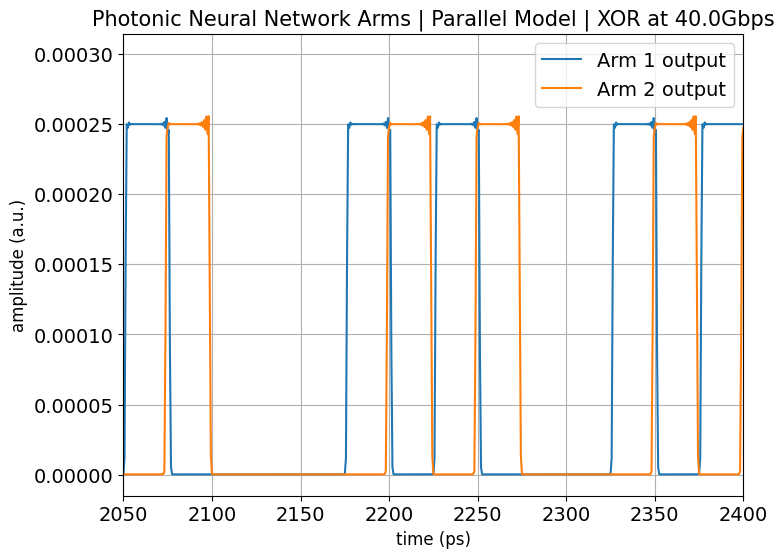

In [ ]:
bitrate = XORPNN.getAttributes('bitrate')
bitrate = bitrate[0]
inter.switchtodesign()
inter.run()

Osci_Out1 = inter.getresult('arm1_osc','signal')['amplitude (a.u.)']
Osci_Out2 = inter.getresult('arm2_osc','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('arm1_osc','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title(f'Photonic Neural Network Arms | Parallel Model | XOR at {np.round(bitrate*1e-9,2)}Gbps',fontsize=15)
# plt.ylim(5e-5,6.7e-5)
plt.xlim(2050,2400)
plt.legend()
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Descombined_dL2_XOR" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

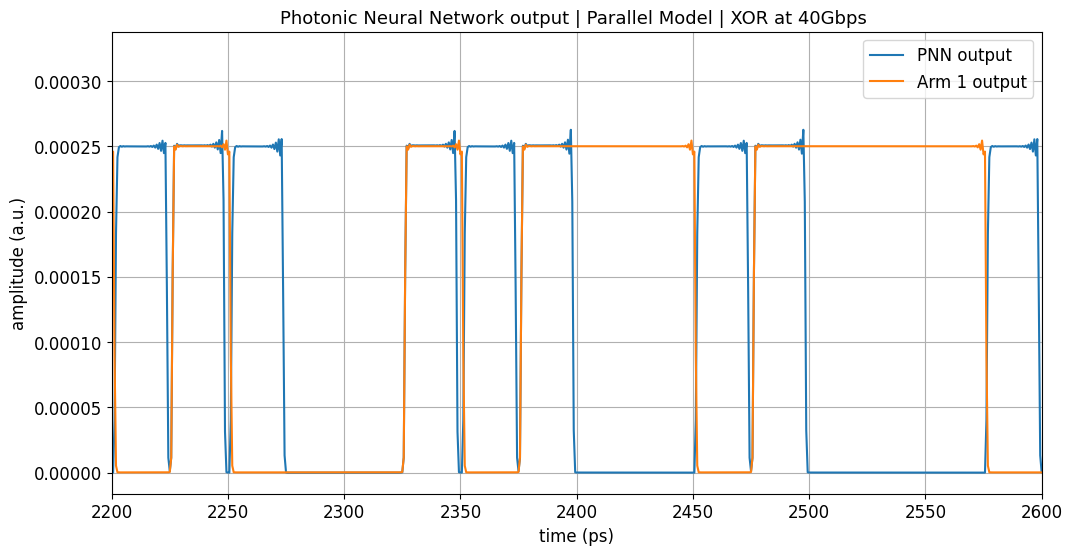

In [8]:
inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Theta 1',1.17949 * np.pi)
inter.setnamed('IDEAL_CELL_5','Theta 2',1.17949 * np.pi)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
inter.run()

Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osciopt_Out1 = inter.getresult('arm1_osc','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(12,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='PNN output')
plt.plot(Osci_time*1e12,Osciopt_Out1,label='Arm 1 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network output | Parallel Model | XOR at 40Gbps ',fontsize=13)
# plt.ylim(0e-6,0.75e-6)
plt.xlim(2200,2600)
plt.legend()
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_dL2_XOR" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

#### XOR | Fiber analysis | 10Gbps model

XOR with optical fiber analysis. 10 Gbps model without insertion loss. Arms C and D blocked

In [3]:
PNNFib = PNN(DelayUnitLen=900e-6,unitsNextTap=8)
PNNFib.transmission(FiberLen=0,PulseAmp=2,PRBSType='PRBS',MZMILoss=0)
PNNFib.simulation(bitrate=10e9)
PNNFib.output(OutputType='mixed')
PNNFib.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 8
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.05/0.05 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 10.0 Gbits/s | Number of Samples: 8192 | Time Window: 5.12e-09 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: disabled
Output Type: mixed


In [4]:
PNNFib.mount(inter)

In [27]:
PNNFib.update(inter)

  0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

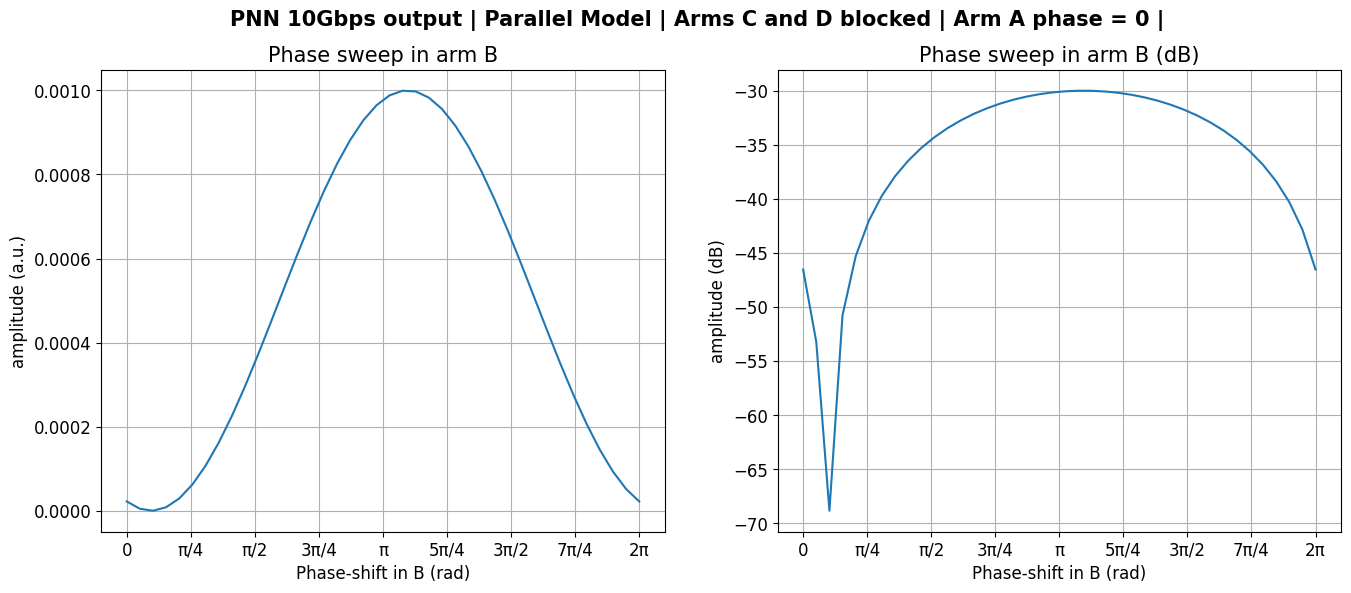

In [5]:
PhaseArray = np.linspace(0,2*np.pi,40)
OutPt = np.zeros(len(PhaseArray))

progress = tqdm(total= len(PhaseArray))

for i in range(len(PhaseArray)):

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_5','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_5','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
    inter.run()

    OutPt[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][500]

    progress.update(1)

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle('PNN 10Gbps output | Parallel Model | Arms C and D blocked | Arm A phase = 0 | ',fontsize=15, fontweight="bold")
dxArray = {'0':0 , 'π/4':pi/4 , 'π/2':pi/2 , '3π/4':3*pi/4 , 'π':pi, '5π/4':5*pi/4, '3π/2':3*pi/2, '7π/4':7*pi/4, '2π':2*pi}

ax[0].plot(PhaseArray,OutPt)
ax[0].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[0].set_xlabel('Phase-shift in B (rad)',fontsize=12)
ax[0].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[0].set_title('Phase sweep in arm B',fontsize=15)
ax[0].grid()

ax[1].plot(PhaseArray,10*np.log10(OutPt))
ax[1].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[1].set_xlabel('Phase-shift in B (rad)',fontsize=12)
ax[1].set_ylabel('amplitude (dB)',fontsize=12)
ax[1].set_title('Phase sweep in arm B (dB)',fontsize=15)
ax[1].grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_XOR_10gbps_C&D_Blocked_B_Sweep" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

display(Math('Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPt*1e8),PhaseArray[int(np.argmin(OutPt))]/np.pi )))
display(Math('Out_{max} = %5.3f*10^{-5}~a.u.~~at~~ %5.5f~π~rad' %( np.max(OutPt*1e5),PhaseArray[int(np.argmax(OutPt))]/np.pi )))

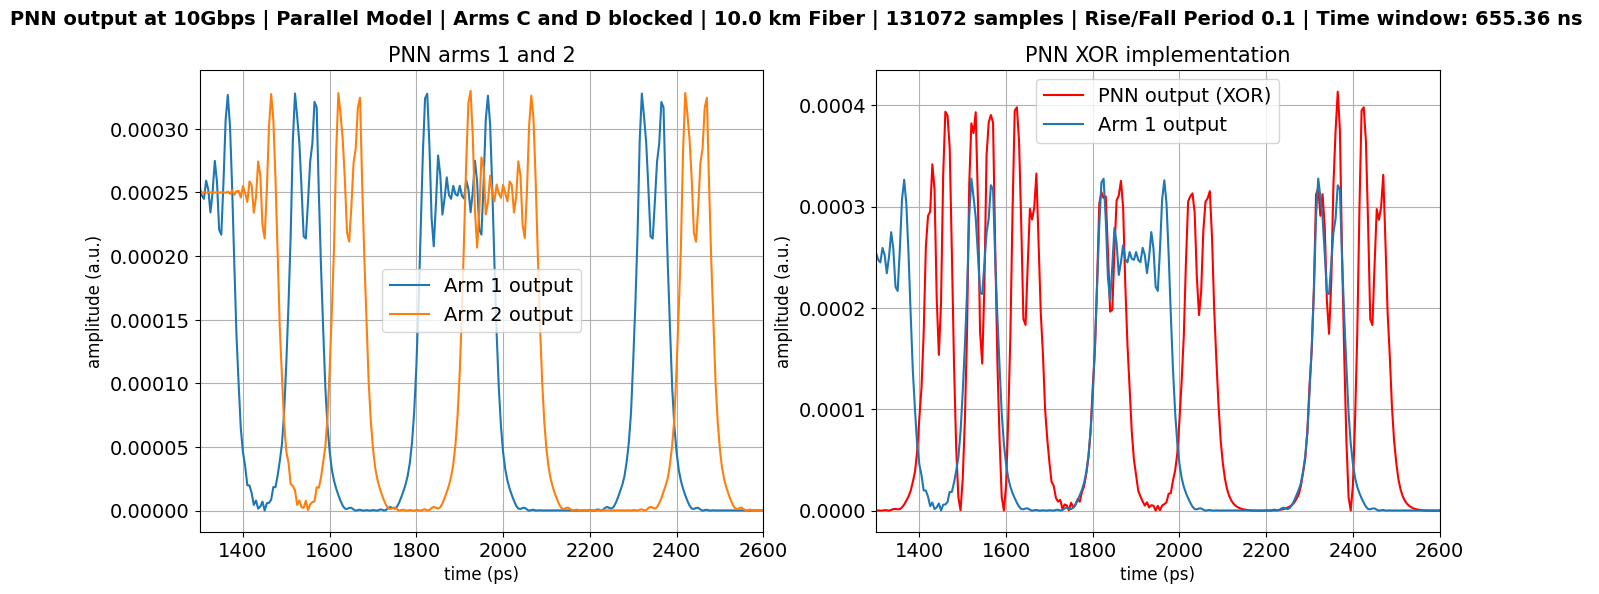

In [27]:
RiseFallTime = 0.1
PNNFib.setAttributes(FiberLen=10e3,timeWindow=5.12e-9*128,numofSamples=8192*16,RiseTime=RiseFallTime,FallTime=RiseFallTime)
PNNFib.update(inter)

inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Theta 1',0.10256*np.pi)
inter.setnamed('IDEAL_CELL_5','Theta 2',0.10256*np.pi)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
inter.run()

Osci_arm1 = inter.getresult('arm1_osc','signal')['amplitude (a.u.)']
Osci_arm2 = inter.getresult('arm2_osc','signal')['amplitude (a.u.)']
Osci_Out = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle(f'PNN output at 10Gbps | Parallel Model | Arms C and D blocked | {PNNFib.getAttributes("FiberLen")[0]*1e-3} km Fiber | {PNNFib.getAttributes("numofSamples")[0]} samples | Rise/Fall Period {RiseFallTime} | Time window: {PNNFib.getAttributes("timeWindow")[0]*1e9} ns ',fontsize=14, fontweight="bold")

ax[0].plot(Osci_time*1e12,Osci_arm1,label='Arm 1 output')
ax[0].plot(Osci_time*1e12,Osci_arm2,label='Arm 2 output')
ax[0].set_xlabel('time (ps)',fontsize=12)
ax[0].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[0].set_title('PNN arms 1 and 2',fontsize=15)
ax[0].set_xlim(1300,2600)
ax[0].legend()
ax[0].grid()

ax[1].plot(Osci_time*1e12,Osci_Out,label='PNN output (XOR)',color='red')
ax[1].plot(Osci_time*1e12,Osci_arm1,label='Arm 1 output')
ax[1].set_xlabel('time (ps)',fontsize=12)
ax[1].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[1].set_title('PNN XOR implementation',fontsize=15)
ax[1].set_xlim(1300,2600)
ax[1].legend()
ax[1].grid()

datapath = '../../data/Media/PNN_Results/ParallelModel/ConvergenceTests'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_XOR_10gbps_refValue" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

samples per bit = 10


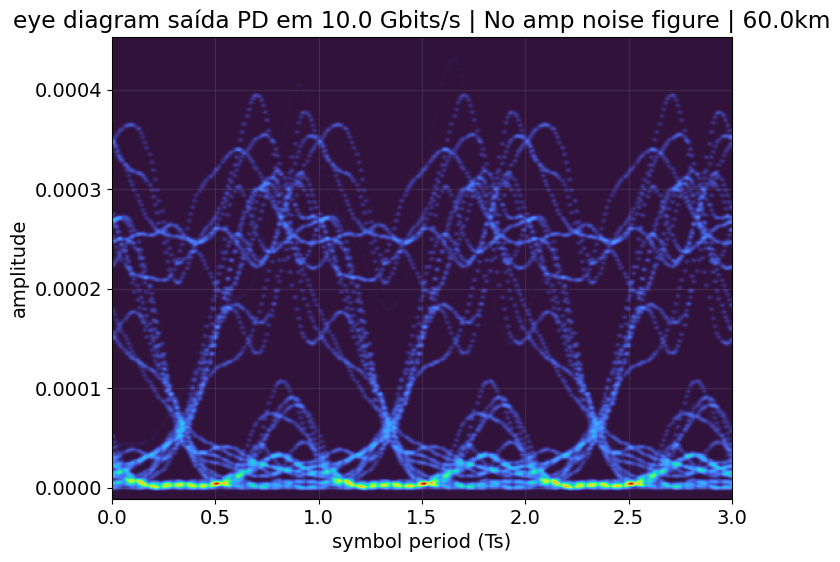

In [68]:
cutMargin = 1
samplespBit = int(PNNFib.getAttributes("numofSamples")[0] / (PNNFib.getAttributes("bitrate")[0]*PNNFib.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('arm1_osc','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

plt.rc('font', size=14) 
fig = eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fancy', plotlabel=f'saída PD em {PNNFib.getAttributes("bitrate")[0]*1e-9} Gbits/s | No amp noise figure | {PNNFib.getAttributes("FiberLen")[0]*1e-3}km')

# datapath = '../../data/Media/PNN_Results/ParallelModel'
# file_count = sum(len(files) for _, _, files in os.walk(datapath))
# fig.get_figure().savefig(datapath+"/"+"Ideal_Combined_XOR_dL4_C&D_Blocked_Photodetector" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fancy', plotlabel=f'saída PD em {PNNFib.getAttributes("bitrate")[0]*1e-9} Gbits/s | No amp noise figure | {PNNFib.getAttributes("FiberLen")[0]*1e-3}km')

##### Convergence Tests

  0%|          | 0/18 [00:00<?, ?it/s]

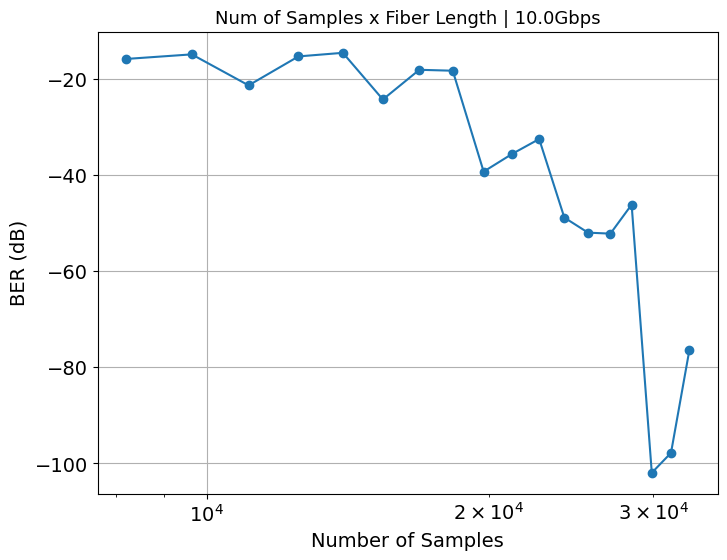

In [38]:
RiseFallTime = 0.1
PNNFib.setAttributes(FiberLen=10e3,timeWindow=5.12e-9*128,RiseTime=RiseFallTime,FallTime=RiseFallTime)

NumSamArray = np.linspace(8192,8192*4,18)
SERArray = np.zeros(len(NumSamArray))

progress = tqdm(total= len(NumSamArray))

for i in range(len(NumSamArray)):
    PNNFib.setAttributes(numofSamples=int(NumSamArray[i]))
    PNNFib.update(inter)
    inter.run()

    SERArray[i] = inter.getresult('Output_VSA','measurement/log of SER')
    progress.update(1)

plt.figure(figsize=(8,6))
plt.plot(NumSamArray,SERArray*10,'-o')
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('BER (dB)', fontsize=14)
plt.title(f'Num of Samples x Fiber Length | {PNNFib.getAttributes("bitrate")[0]*1e-9}Gbps', fontsize=13)
plt.xscale('log')
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel/ConvergenceTests'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"10gbps_NumofSam" + ".png", transparent=False, facecolor="white", bbox_inches="tight")
plt.savefig(datapath+"/"+"10gbps_NumofSam_zoomed" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

  0%|          | 0/20 [00:00<?, ?it/s]

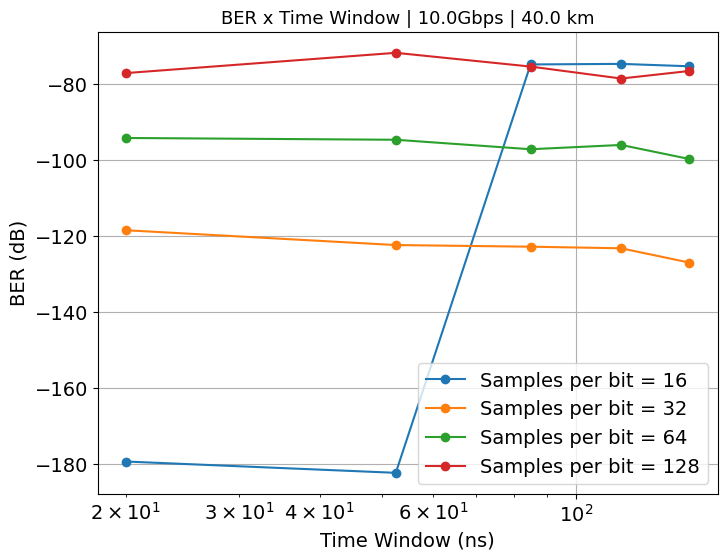

In [52]:
RiseFallTime = 0.1
PNNFib.setAttributes(FiberLen=40e3,RiseTime=RiseFallTime,FallTime=RiseFallTime)

SpbArray = [16,32,64,128]
timeWArray = np.linspace(20e-9,150e-9,5)
SERArray = np.zeros((len(timeWArray),len(SpbArray)))

progress = tqdm(total= len(timeWArray)*len(SpbArray))

for j in range(len(SpbArray)):
    for i in range(len(timeWArray)):
        PNNFib.setAttributes(timeWindow=timeWArray[i])
        PNNFib.setAttributes(numofSamples=SpbArray[j]*timeWArray[i]*PNNFib.getAttributes("bitrate")[0])
        PNNFib.update(inter)
        inter.run()

        SERArray[i,j] = inter.getresult('Output_VSA','measurement/log of SER')
        progress.update(1)

plt.figure(figsize=(8,6))
for j in range(len(SpbArray)):
    plt.plot(timeWArray*1e9,SERArray[:,j]*10,'-o',label=f'Samples per bit = {SpbArray[j]}')
plt.xlabel('Time Window (ns)', fontsize=14)
plt.ylabel('BER (dB)', fontsize=14)
plt.title(f'BER x Time Window | {PNNFib.getAttributes("bitrate")[0]*1e-9}Gbps | {PNNFib.getAttributes("FiberLen")[0]*1e-3} km', fontsize=13)
plt.xscale('log')
plt.grid()
plt.legend()

datapath = '../../data/Media/PNN_Results/ParallelModel/ConvergenceTests'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"10gbps_NumofSam" + ".png", transparent=False, facecolor="white", bbox_inches="tight")
plt.savefig(datapath+"/"+"10gbps_TimeWin" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

##### Fiber len x BER

  0%|          | 0/14 [00:00<?, ?it/s]

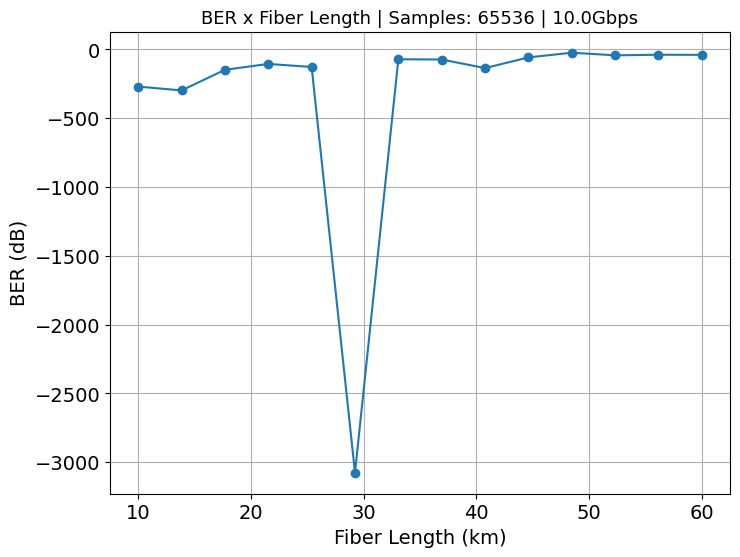

In [58]:
RiseFallTime = 0.1
PNNFib.setAttributes(timeWindow=5.12e-9*128,numofSamples=8192*8,RiseTime=RiseFallTime,FallTime=RiseFallTime)

LenArray = np.linspace(10e3,60e3,14)
SERArray = np.zeros(len(LenArray))

progress = tqdm(total= len(LenArray))

for i in range(len(LenArray)):
    PNNFib.transmission(FiberLen=LenArray[i],PRBSType='codeword')
    PNNFib.update(inter)
    inter.setnamed('PRBS','codeword','00101101110011101010000111101')
    inter.run()
    SERArray[i] = inter.getresult('Output_VSA','measurement/log of SER')

    progress.update(1)

plt.figure(figsize=(8,6))
plt.plot(LenArray*1e-3,SERArray*10,'-o')
plt.xlabel('Fiber Length (km)', fontsize=14)
plt.ylabel('BER (dB)', fontsize=14)
plt.title(f'BER x Fiber Length | Samples: {PNNFib.getAttributes("numofSamples")[0]} | {PNNFib.getAttributes("bitrate")[0]*1e-9}Gbps', fontsize=13)
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_XOR_10gbps_BERxLen" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

In [61]:
LenArray

array([10000.        , 13846.15384615, 17692.30769231, 21538.46153846,
       25384.61538462, 29230.76923077, 33076.92307692, 36923.07692308,
       40769.23076923, 44615.38461538, 48461.53846154, 52307.69230769,
       56153.84615385, 60000.        ])

In [63]:
SERArray2 = np.array([ -269.89218378,  -297.91160847,  -148.04668573,  -105.26565438, -127.59720194, -71.36680496,   -73.2007041 , -135.58499592,   -57.8574463 ,   -23.8656423 ,   -42.82585003, -38.46313404,   -39.3469273 ])
LenArray2 = np.array([10000.        , 13846.15384615, 17692.30769231, 21538.46153846,
       25384.61538462, 33076.92307692, 36923.07692308,
       40769.23076923, 44615.38461538, 48461.53846154, 52307.69230769,
       56153.84615385, 60000.        ])

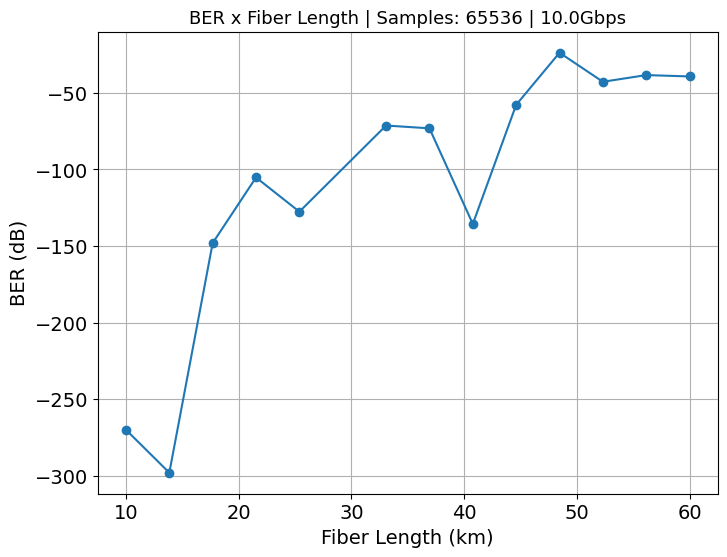

In [66]:
plt.figure(figsize=(8,6))
plt.plot(LenArray2*1e-3,SERArray2,'-o')
plt.xlabel('Fiber Length (km)', fontsize=14)
plt.ylabel('BER (dB)', fontsize=14)
plt.title(f'BER x Fiber Length | Samples: {PNNFib.getAttributes("numofSamples")[0]} | {PNNFib.getAttributes("bitrate")[0]*1e-9}Gbps', fontsize=13)
plt.grid()

#### XOR | 50ps model (article)

XOR with article model (50 ps) at 20 Gbps. Analysis without insertion loss (Arms C and D blocked) and with insertion loss (All arms used)

In [13]:
PNN50ps = PNN(DelayUnitLen=900e-6,unitsNextTap=4)
PNN50ps.transmission(FiberLen=0,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1)
PNN50ps.simulation(bitrate=5e9,timeWindow=5.12e-9*16/4,numofSamples=65536/8)
PNN50ps.output(OutputType='mixed')
PNN50ps.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 4 | Wvg Loss: 0 dB/m
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 5.0 Gbits/s | Number of Samples: 8192.0 | Time Window: 2.048e-08 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: disabled
Output Type: mixed


In [14]:
PNN50ps.mount(inter)

In [ ]:
PNN50ps.update(inter)

  0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

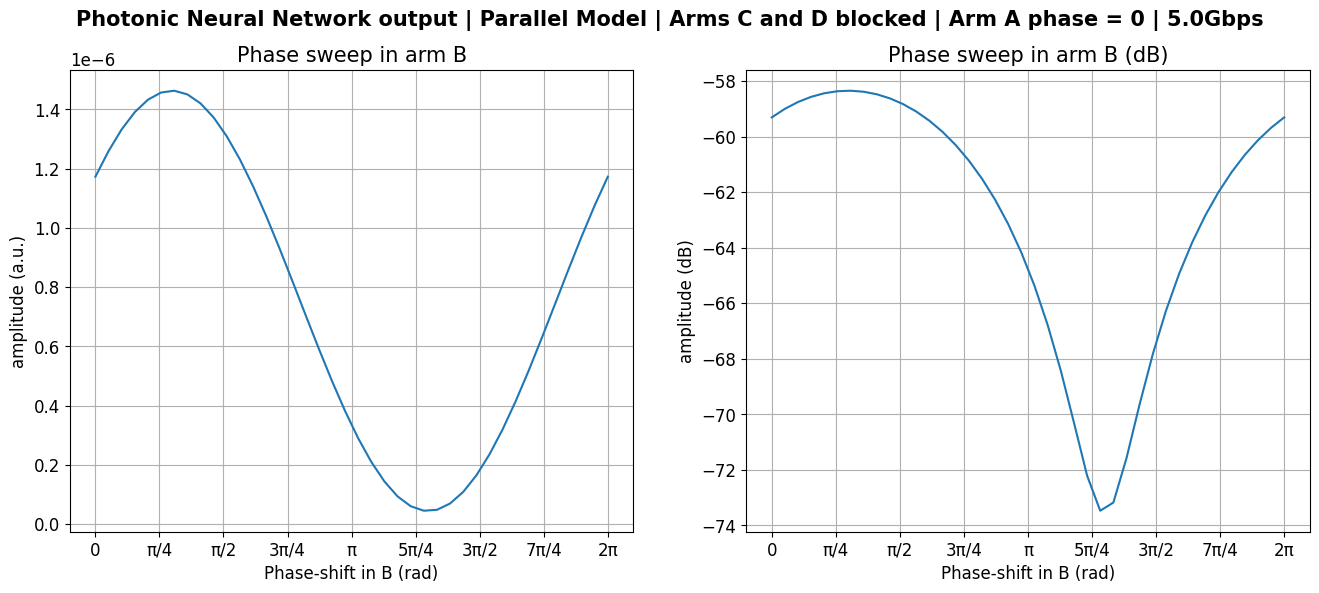

In [16]:
PhaseArray = np.linspace(0,2*np.pi,40)
OutPt = np.zeros(len(PhaseArray))

progress = tqdm(total= len(PhaseArray))

for i in range(len(PhaseArray)):

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_5','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_5','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
    inter.run()

    OutPt[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][500]

    progress.update(1)

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle(f'Photonic Neural Network output | Parallel Model | Arms C and D blocked | Arm A phase = 0 | {PNN50ps.getAttributes("bitrate")[0]*1e-9}Gbps',fontsize=15, fontweight="bold")
dxArray = {'0':0 , 'π/4':pi/4 , 'π/2':pi/2 , '3π/4':3*pi/4 , 'π':pi, '5π/4':5*pi/4, '3π/2':3*pi/2, '7π/4':7*pi/4, '2π':2*pi}

ax[0].plot(PhaseArray,OutPt)
ax[0].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[0].set_xlabel('Phase-shift in B (rad)',fontsize=12)
ax[0].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[0].set_title('Phase sweep in arm B',fontsize=15)
ax[0].grid()

ax[1].plot(PhaseArray,10*np.log10(OutPt))
ax[1].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[1].set_xlabel('Phase-shift in B (rad)',fontsize=12)
ax[1].set_ylabel('amplitude (dB)',fontsize=12)
ax[1].set_title('Phase sweep in arm B (dB)',fontsize=15)
ax[1].grid()

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Ideal_Combined_XOR_dL4_C&D_Blocked_B_Sweep" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

display(Math('Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPt*1e8),PhaseArray[int(np.argmin(OutPt))]/np.pi )))
display(Math('Out_{max} = %5.3f*10^{-5}~a.u.~~at~~ %5.5f~π~rad' %( np.max(OutPt*1e5),PhaseArray[int(np.argmax(OutPt))]/np.pi )))

In [ ]:
bitrate = PNN50ps.getAttributes('bitrate')
bitrate = bitrate[0]
inter.switchtodesign()
inter.setnamed('IDEAL_CELL_5','Theta 1',1.28205*np.pi)
inter.setnamed('IDEAL_CELL_5','Theta 2',1.28205*np.pi)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
inter.run()

samples per bit = 40


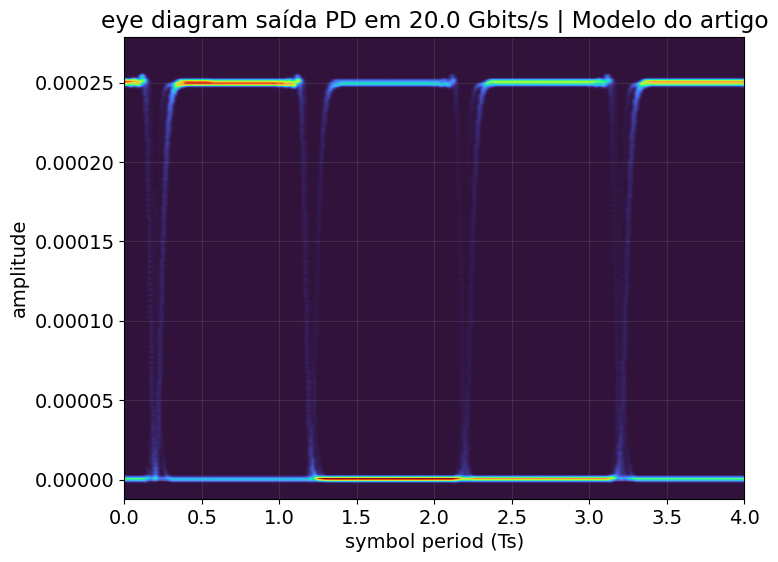

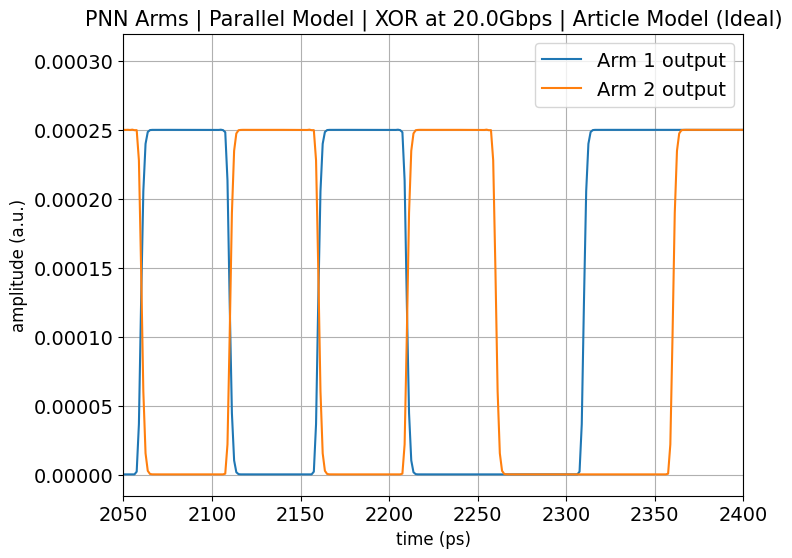

In [ ]:
cutMargin = 8
samplespBit = int(PNN50ps.getAttributes("numofSamples")[0] / (PNN50ps.getAttributes("bitrate")[0]*PNN50ps.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('OSC_2','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

plt.rc('font', size=14) 
fig = eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=4, ptype='fancy', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Modelo do artigo (Ideal)')

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
fig.get_figure().savefig(datapath+"/"+"Article_XOR_EYE_Ideal" + ".png", transparent=False, facecolor="white", bbox_inches="tight")


Osci_Out1 = inter.getresult('arm1_osc','signal')['amplitude (a.u.)']
Osci_Out2 = inter.getresult('arm2_osc','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('arm1_osc','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title(f'PNN Arms | Parallel Model | XOR at {np.round(bitrate*1e-9,2)}Gbps | Article Model (Ideal)',fontsize=15)
# plt.ylim(5e-5,6.7e-5)
plt.xlim(2050,2400)
plt.legend()
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Article_Arms_OSC_Ideal" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=4, ptype='fancy', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Modelo do artigo')

##### Insertion Loss Analysis

In [104]:
PNN50ps = PNN(DelayUnitLen=900e-6,unitsNextTap=4,WvgLoss=591.86)
PNN50ps.transmission(FiberLen=0,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1)
PNN50ps.simulation(bitrate=5e9,timeWindow=5.12e-9*16,numofSamples=65536)
PNN50ps.output(OutputType='mixed')
PNN50ps.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 4 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 5.0 Gbits/s | Number of Samples: 65536 | Time Window: 8.192e-08 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: disabled
AWGN post PD: disabled
Optical Filter: disabled
Output Type: mixed


In [105]:
PNN50ps.mount(inter)

In [106]:
inter.switchtolayout()
inter.run()

Osci_Out1 = inter.getresult('arm1_osc','signal')['amplitude (a.u.)']
Osci_Out2 = inter.getresult('arm2_osc','signal')['amplitude (a.u.)']
Osci_Out3 = inter.getresult('arm3_osc','signal')['amplitude (a.u.)']
Osci_Out4 = inter.getresult('arm4_osc','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('arm1_osc','signal')['time']

Power Max: Arm A = 0.00015873141264773465 | Arm B = 9.718368024116045e-05 | Arm C = 5.950092097974073e-05 | Arm D = 3.642952818686546e-05
Wave amplitude Max: Arm A = 0.01259886553018702 | Arm B = 0.009858178342937424 | Arm C = 0.007713684008289472 | Arm D = 0.006035687880172853


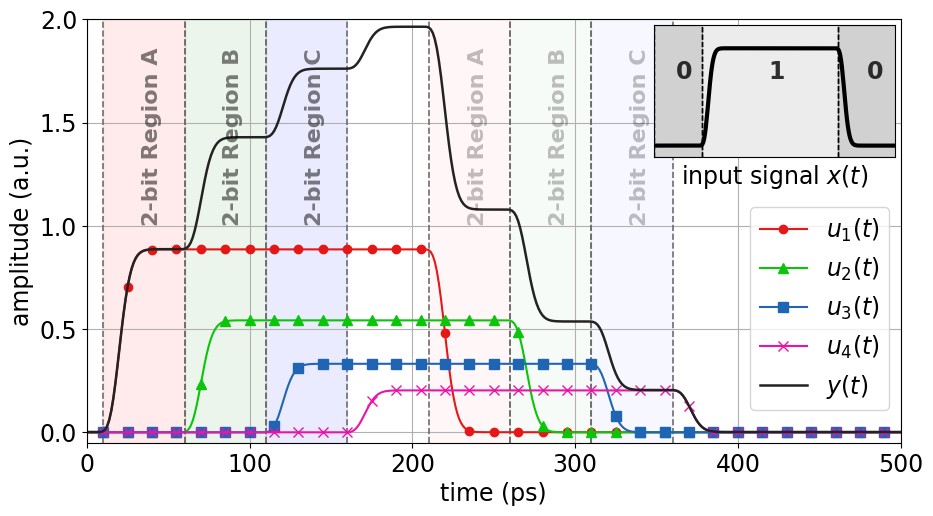

: 

In [ ]:
plt.figure(figsize=(10.5,5.5))
plt.xlabel('time (ps)',fontsize=17)
plt.ylabel('amplitude (a.u.)',fontsize=17)
# plt.title(f'Photonic Neural Network Arms | Parallel Model | {PNN50ps.getAttributes("bitrate")[0]*1e-9}Gbps',fontsize=15)
plt.ylim(-0.05,2)
plt.xlim(0,500)
plt.grid()

plt.tick_params(axis='x', which='both', top=False, bottom=True, labelsize=17)
plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=17)

regions = [
    (10, 60, '2-bit Region A', 'red', 0.08, 0.5),
    (60, 110, '2-bit Region B', 'green', 0.08, 0.5),
    (110, 160, '2-bit Region C', 'blue', 0.08, 0.5),
    (210, 260, '2-bit Region A', 'red', 0.03, 0.25),
    (260, 310, '2-bit Region B', 'green', 0.03, 0.25),
    (310, 360, '2-bit Region C', 'blue', 0.03, 0.25),
]

for xstart, xend, label, color, alphaCol, alphaText in regions:
    plt.axvspan(xstart, xend, color=color, alpha=alphaCol)
    plt.axvline(xstart, linestyle='--', color="#6E6E6E", linewidth=1.2)
    plt.axvline(xend, linestyle='--', color="#6E6E6E", linewidth=1.2)
    plt.text((xstart + xend) / 2 + 5, 1, label,
             rotation=90, fontsize=16, va='bottom', ha='center',
             fontweight='bold', alpha=alphaText)

plt.plot(Osci_time*1e12 -8000,Osci_Out1/np.max(Osci_Out1),label='$u_1(t)$',color="#e51717",markevery=12,marker='o')
plt.plot(Osci_time*1e12 -8000,Osci_Out2/np.max(Osci_Out1),label='$u_2(t)$',color="#0bc50b",markersize=7,markevery=12,marker='^')
plt.plot(Osci_time*1e12 -8000,Osci_Out3/np.max(Osci_Out1),label='$u_3(t)$',color="#1f65b4",markersize=7,markevery=12,marker='s')
plt.plot(Osci_time*1e12 -8000,Osci_Out4/np.max(Osci_Out1),label='$u_4(t)$',color="#e914a9",markersize=7,markevery=12,marker='x')    
plt.plot(Osci_time*1e12 -8000,(Osci_Out1+Osci_Out2+Osci_Out3+Osci_Out4)/np.max(Osci_Out1),label='$y(t)$',color="#242323",linewidth=1.8)
plt.legend(fontsize=17,bbox_to_anchor=(1, 0.05),loc='lower right')
    
# Inset
inset_ax = plt.axes([0.665, 0.63, 0.23, 0.24])  # [left, bottom, width, height]
inset_ax.plot(Osci_time*1e12 -7940,Osci_Out1/np.max(Osci_Out1),label='$u_1(t)$',color="#000000",markevery=12,linewidth=3)
inset_ax.set_xlim(0, 355)
inset_ax.set_ylim(-0.1, 1.1)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlabel('input signal $x(t)$',fontsize=17)
inset_ax.tick_params(labelsize=8)
inset_ax.grid(True)

regions = [
    (0, 70, '0', "#1B1B1B"),
    (70, 270, '1', "#A2A2A2"),
    (270, 360, '0', "#1B1B1B"),
]

for xstart, xend, label, color in regions:
    plt.axvspan(xstart, xend, color=color, alpha=0.2)
    plt.axvline(xstart, linestyle='--', color='black', linewidth=1)
    plt.axvline(xend, linestyle='--', color='black', linewidth=1)
    plt.text((xstart + xend) / 2 + 10, 0.565, label,fontsize=17, va='bottom', ha='center',
             fontweight='bold', alpha=0.8)

plt.savefig('PNNMemory.pdf', format='pdf', bbox_inches='tight')

print(f'Power Max: Arm A = {np.max(Osci_Out1[5400:6200])} | Arm B = {np.max(Osci_Out2[5400:6200])} | Arm C = {np.max(Osci_Out3[5400:6200])} | Arm D = {np.max(Osci_Out4[5400:6200])}')
print(f'Wave amplitude Max: Arm A = {np.sqrt(np.max(Osci_Out1[5400:6200]))} | Arm B = {np.sqrt(np.max(Osci_Out2[5400:6200]))} | Arm C = {np.sqrt(np.max(Osci_Out3[5400:6200]))} | Arm D = {np.sqrt(np.max(Osci_Out4[5400:6200]))}')

# datapath = '../../../data/Media/PNN_Results/ParallelModel/16Gbps'
# file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"insertionLoss_16Gbps" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

# Osci_Out = inter.getresult('OSC_2','signal')['amplitude (a.u.)']

# plt.figure(figsize=(8,6))
# plt.plot(Osci_time*1e12,Osci_Out,label='PNN output')
# plt.xlabel('time (ps)',fontsize=17)
# plt.ylabel('amplitude (a.u.)',fontsize=17)
# plt.title(f'PNN Output | Parallel Model | {PNN50ps.getAttributes("bitrate")[0]*1e-9}Gbps | No phase shifting',fontsize=15)
# plt.xlim(4800,5200)
# plt.legend()
# plt.grid()

# datapath = '../../../data/Media/PNN_Results/ParallelModel/16Gbps'
# file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"insertionLoss_16Gbps_PNN_NoPhaseShift" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

In [71]:
PNN50ps.simulation(timeWindow=5.12e-9*16/8,numofSamples=65536/8)
PNN50ps.update(inter)

  0%|          | 0/135 [00:00<?, ?it/s]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

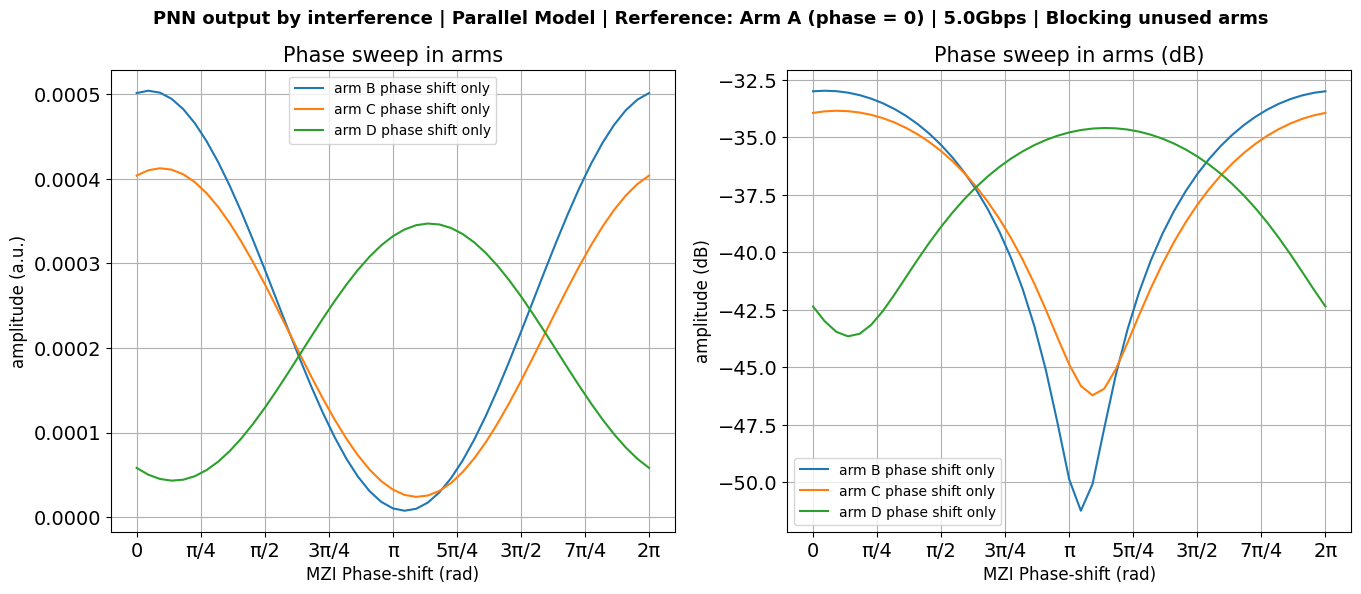

In [75]:
PhaseArray = np.linspace(0,2*np.pi,45)
OutPtB = np.zeros(len(PhaseArray))
OutPtC = np.zeros(len(PhaseArray))
OutPtD = np.zeros(len(PhaseArray))

progress = tqdm(total= len(PhaseArray)*3)

for i in range(len(PhaseArray)):

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_5','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_5','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_6','Theta 1',0)
    inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_7','Theta 1',0)
    inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
    inter.run()
    OutPtB[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][5900]
    progress.update(1)

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_6','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_6','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_5','Theta 1',0)
    inter.setnamed('IDEAL_CELL_5','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_7','Theta 1',0)
    inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
    inter.run()
    OutPtC[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][5900]
    progress.update(1)

    inter.switchtolayout()
    inter.setnamed('IDEAL_CELL_7','Theta 1',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_7','Theta 2',PhaseArray[i])
    inter.setnamed('IDEAL_CELL_5','Theta 1',0)
    inter.setnamed('IDEAL_CELL_5','Theta 2',np.pi)
    inter.setnamed('IDEAL_CELL_6','Theta 1',0)
    inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
    inter.run()
    OutPtD[i] = inter.getresult('OSC_2','signal')['amplitude (a.u.)'][5900]
    progress.update(1)

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle(f'PNN output by interference | Parallel Model | Rerference: Arm A (phase = 0) | {PNN50ps.getAttributes("bitrate")[0]*1e-9}Gbps | Blocking unused arms',fontsize=13, fontweight="bold")
dxArray = {'0':0 , 'π/4':pi/4 , 'π/2':pi/2 , '3π/4':3*pi/4 , 'π':pi, '5π/4':5*pi/4, '3π/2':3*pi/2, '7π/4':7*pi/4, '2π':2*pi}

ax[0].plot(PhaseArray,OutPtB,label='arm B phase shift only')
ax[0].plot(PhaseArray,OutPtC,label='arm C phase shift only')
ax[0].plot(PhaseArray,OutPtD,label='arm D phase shift only')
ax[0].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[0].set_xlabel('MZI Phase-shift (rad)',fontsize=12)
ax[0].set_ylabel('amplitude (a.u.)',fontsize=12)
ax[0].set_title('Phase sweep in arms',fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=10)

ax[1].plot(PhaseArray,10*np.log10(OutPtB),label='arm B phase shift only')
ax[1].plot(PhaseArray,10*np.log10(OutPtC),label='arm C phase shift only')
ax[1].plot(PhaseArray,10*np.log10(OutPtD),label='arm D phase shift only')
ax[1].set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax[1].set_xlabel('MZI Phase-shift (rad)',fontsize=12)
ax[1].set_ylabel('amplitude (dB)',fontsize=12)
ax[1].set_title('Phase sweep in arms (dB)',fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=10)

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"PNN_interferenceSweep_eachArm" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

display(Math('Arm B:~~Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPtB*1e8),PhaseArray[int(np.argmin(OutPtB))]/np.pi )))
display(Math('Arm B:~~Out_{max} = %5.3f*10^{-5}~a.u.~~at~~ %5.5f~π~rad' %( np.max(OutPtB*1e5),PhaseArray[int(np.argmax(OutPtB))]/np.pi )))
display(Math('Arm C:~~Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPtC*1e8),PhaseArray[int(np.argmin(OutPtC))]/np.pi )))
display(Math('Arm C:~~Out_{max} = %5.3f*10^{-5}~a.u.~~at~~ %5.5f~π~rad' %( np.max(OutPtC*1e5),PhaseArray[int(np.argmax(OutPtC))]/np.pi )))
display(Math('Arm D:~~Out_{min} = %5.3f*10^{-8}~a.u.~~at~~ %5.5f~π~rad' %( np.min(OutPtD*1e8),PhaseArray[int(np.argmin(OutPtD))]/np.pi )))
display(Math('Arm D:~~Out_{max} = %5.3f*10^{-5}~a.u.~~at~~ %5.5f~π~rad' %( np.max(OutPtD*1e5),PhaseArray[int(np.argmax(OutPtD))]/np.pi )))

In [134]:
PNN50ps = PNN(DelayUnitLen=900e-6,unitsNextTap=4,WvgLoss=591.86)
PNN50ps.transmission(FiberLen=0,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1)
PNN50ps.simulation(bitrate=5e9,timeWindow=5.12e-9*16,numofSamples=65536)
PNN50ps.output(OutputType='mixed')
PNN50ps.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 4 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 5.0 Gbits/s | Number of Samples: 65536 | Time Window: 8.192e-08 s
photoreceptor :: PD Responsivity: 1 A/W | PD Dark Current: 0 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: disabled
Output Type: mixed


In [55]:
PNN50ps.mount(inter)

In [135]:
PNN50ps.update(inter)

1st Region

In [140]:
BAngle = 175
CAngle = 144
DAngle = 303

2nd Region

In [141]:
BAngle = 0
CAngle = 140
DAngle = 235

3rd Region

In [144]:
BAngle = 135
CAngle = 45
DAngle = 225

In [145]:
BRad = 0.04545*np.pi + BAngle*np.pi/180
CRad = 0.09091*np.pi + CAngle*np.pi/180
DRad = 1.13636*np.pi + DAngle*np.pi/180
print(f'BRad: {BRad/np.pi} pi | CRad: {CRad/np.pi} pi | DRad: {DRad/np.pi} pi')

bitrate = PNN50ps.getAttributes('bitrate')
bitrate = bitrate[0]
inter.switchtodesign()
inter.setnamed('IDEAL_CELL_5','Theta 1',BRad)
inter.setnamed('IDEAL_CELL_5','Theta 2',BRad)
inter.setnamed('IDEAL_CELL_6','Theta 1',CRad)
inter.setnamed('IDEAL_CELL_6','Theta 2',CRad)
inter.setnamed('IDEAL_CELL_7','Theta 1',DRad)
inter.setnamed('IDEAL_CELL_7','Theta 2',DRad)
inter.run()

BRad: 0.7954500000000001 pi | CRad: 0.34091 pi | DRad: 2.38636 pi


samples per bit = 160


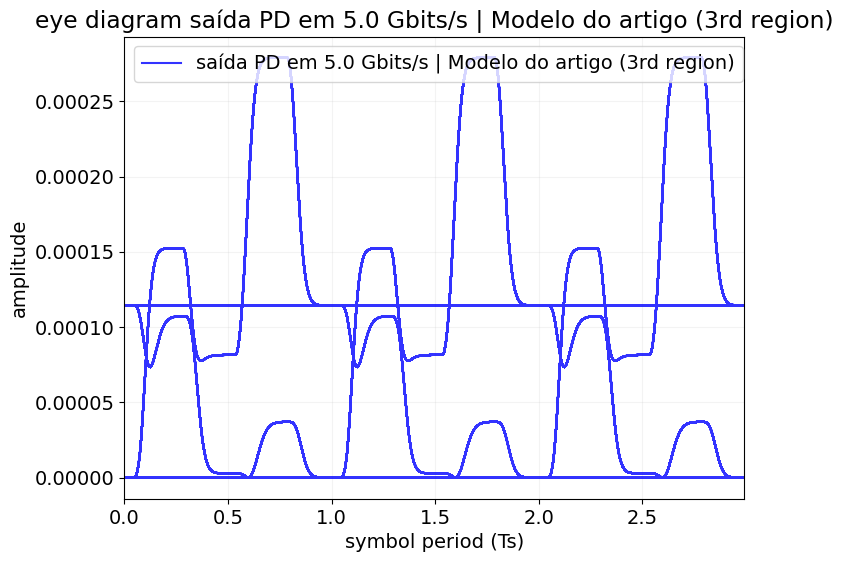

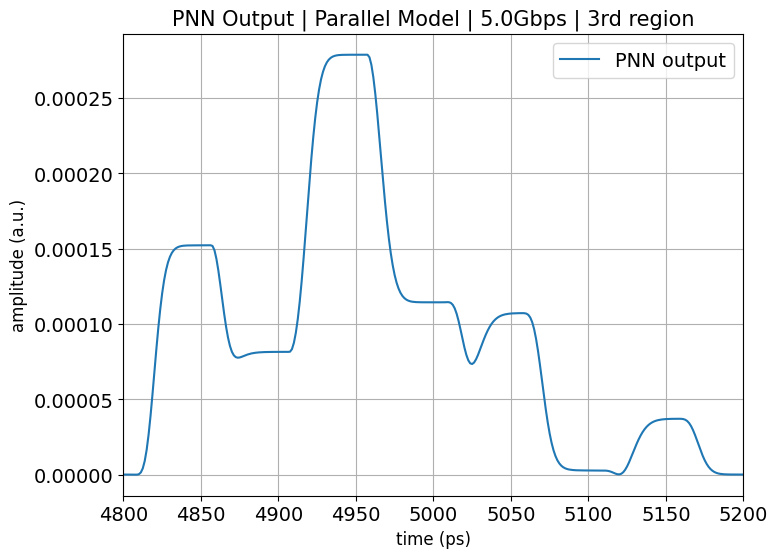

In [146]:
Osci_time = inter.getresult('arm1_osc','signal')['time']
Osci_Out = inter.getresult('OSC_2','signal')['amplitude (a.u.)']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out,label='PNN output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title(f'PNN Output | Parallel Model | {PNN50ps.getAttributes("bitrate")[0]*1e-9}Gbps | 3rd region',fontsize=15)
plt.xlim(4800,5200)
plt.legend()
plt.grid()

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"insertionLoss_5Gbps_PNN_3rdRegion" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

cutMargin = 8
samplespBit = int(PNN50ps.getAttributes("numofSamples")[0] / (PNN50ps.getAttributes("bitrate")[0]*PNN50ps.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('OSC_2','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

plt.rc('font', size=14) 
fig = eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fast', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Modelo do artigo (3rd region)')

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
fig.get_figure().savefig(datapath+"/"+"insertionLoss_5Gbps_PNN_3rdRegion_EYE" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fast', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Modelo do artigo (3rd region)')

##### Photodiode Analysis

Photodiode: Thorlabs DXM20AF
- Responsivity: 0.9 A/W
- Dark Current: 50nA

In [150]:
PNN50ps = PNN(DelayUnitLen=900e-6,unitsNextTap=4)
PNN50ps.transmission(FiberLen=0,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1)
PNN50ps.simulation(bitrate=20e9,timeWindow=5.12e-9*16,numofSamples=65536)
PNN50ps.output(OutputType='mixed')
PNN50ps.photoreceptor(PDResponsivity=0.9,PDDarkCurrent=50e-9,TogglePDSNoise=True)
PNN50ps.showParameters()

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 4 | Wvg Loss: 0 dB/m
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 20.0 Gbits/s | Number of Samples: 65536 | Time Window: 8.192e-08 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: enabled
Output Type: mixed


In [149]:
PNN50ps.mount(inter)

In [19]:
PNN50ps.update(inter)

In [ ]:
bitrate = PNN50ps.getAttributes('bitrate')[0]
inter.switchtodesign()
inter.setnamed('IDEAL_CELL_5','Theta 1',1.02564*np.pi)
inter.setnamed('IDEAL_CELL_5','Theta 2',1.02564*np.pi)
inter.setnamed('IDEAL_CELL_6','Theta 2',np.pi)
inter.setnamed('IDEAL_CELL_7','Theta 2',np.pi)
inter.run()

samples per bit = 40


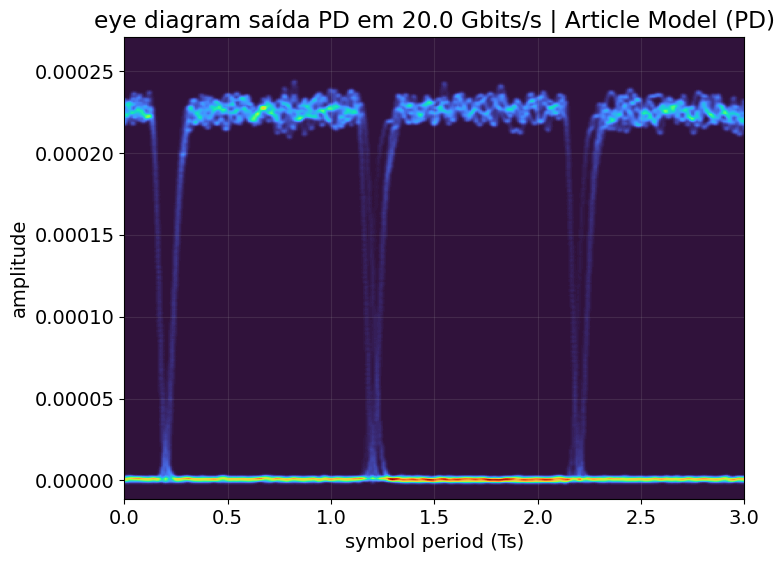

In [18]:
cutMargin = 8
samplespBit = int(PNN50ps.getAttributes("numofSamples")[0] / (PNN50ps.getAttributes("bitrate")[0]*PNN50ps.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('OSC_2','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

plt.rc('font', size=14) 
fig = eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=2, ptype='fancy', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Article Model (PD)')

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
fig.get_figure().savefig(datapath+"/"+"Article_XOR_EYE_RealPhotodetector" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fancy', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Article Model (PD)')

In [162]:
PNN50ps.general(WvgLoss=591.86)
PNN50ps.simulation(bitrate=5e9,timeWindow=5.12e-9*16,numofSamples=65536)
PNN50ps.showParameters()
PNN50ps.mount(inter)

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 4 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 0.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 5.0 Gbits/s | Number of Samples: 65536 | Time Window: 8.192e-08 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
-----------------------------------------------------------------------------------
PD Thermal Noise: disabled
PD Shot Noise: enabled
Output Type: mixed


In [163]:
BAngle = 175
CAngle = 144
DAngle = 303

BRad = 0.04545*np.pi + BAngle*np.pi/180
CRad = 0.09091*np.pi + CAngle*np.pi/180
DRad = 1.13636*np.pi + DAngle*np.pi/180
print(f'BRad: {BRad/np.pi} pi | CRad: {CRad/np.pi} pi | DRad: {DRad/np.pi} pi')

bitrate = PNN50ps.getAttributes('bitrate')
bitrate = bitrate[0]
inter.switchtodesign()
inter.setnamed('IDEAL_CELL_5','Theta 1',BRad)
inter.setnamed('IDEAL_CELL_5','Theta 2',BRad)
inter.setnamed('IDEAL_CELL_6','Theta 1',CRad)
inter.setnamed('IDEAL_CELL_6','Theta 2',CRad)
inter.setnamed('IDEAL_CELL_7','Theta 1',DRad)
inter.setnamed('IDEAL_CELL_7','Theta 2',DRad)
inter.run()

BRad: 1.017672222222222 pi | CRad: 0.8909100000000001 pi | DRad: 2.819693333333333 pi


samples per bit = 160


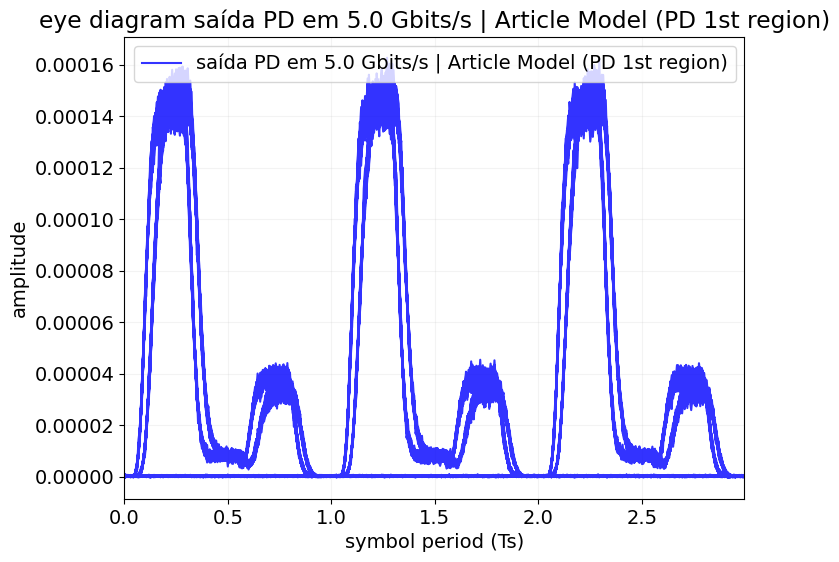

In [164]:
cutMargin = 8
samplespBit = int(PNN50ps.getAttributes("numofSamples")[0] / (PNN50ps.getAttributes("bitrate")[0]*PNN50ps.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('OSC_2','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

plt.rc('font', size=14) 
fig = eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=2, ptype='fancy', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Article Model (PD PD 1st region)')

datapath = '../../data/Media/PNN_Results/ParallelModel/Article_Model'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
fig.get_figure().savefig(datapath+"/"+"Article_XOR_EYE_RealPhotodetector_1stRegion" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fast', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | Article Model (PD 1st region)')

### Particle Swarm Analysis

Particle Swarm Algorithm Analysis. Including:
- Algorithm for Threshold and Sampling position optimization
- Cornfield Vector Application
- Algorithm applied on the PNN
- BER x SNR analysis with Paralization analysis:
    - Agent parallel simulation
    - Power Spectral Density parallel simulation

In [51]:
PNNPSO = PNN(DelayUnitLen=900e-6,unitsNextTap=4,WvgLoss=588.88)
PNNPSO.transmission(FiberLen=10e3,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1,ToggleBitOp=True)
PNNPSO.simulation(bitrate=16e9,timeWindow=5.12e-9*128/4,numofSamples=65536*2)
PNNPSO.output(OutputType='mixed',ToggleAWGN=False,ToggleOptFilter=True)
PNNPSO.photoreceptor(PDResponsivity=0.9,PDDarkCurrent=50e-9,TogglePDSNoise=True)
PNNPSO.showParameters()

print(f'Number of Bits = {PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]}')
print(f'Samples per Bits = {(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))}')

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.999999999999999e-10 μm | Units for next tap: 4 | Wvg Loss: 588.88 dB/m
transmission :: Fiber length: 10.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 16.0 Gbits/s | Number of Samples: 131072 | Time Window: 1.6384e-07 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: enabled
AWGN post PD: disabled
Optical Filter: enabled
Output Type: mixed
Number of Bits = 2621.44
Samples per Bits = 50.0


In [54]:
PNNPSO.update(inter)

In [53]:
PNNPSO.mount(inter)

#### Create Optimization (INTERCONNECT)

In [311]:
MaxGen = 20
GenSize = 10
Tol = 1e-3

inter.deletesweep('ParticleSwarmOptimization')
inter.addsweep(1)
inter.setsweep('optimization','name','ParticleSwarmOptimization')
inter.setsweep('ParticleSwarmOptimization','type','Minimum')
inter.setsweep('ParticleSwarmOptimization','maximum generations',MaxGen)
inter.setsweep('ParticleSwarmOptimization','generation size',GenSize)
inter.setsweep('ParticleSwarmOptimization','tolerance',Tol)

ArmBParam = {'Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number',  'Min':0,  'Max':2*np.pi}
ArmCParam = {'Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number',  'Min':0,  'Max':2*np.pi}
ArmDParam = {'Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number',  'Min':0,  'Max':2*np.pi}
inter.addsweepparameter('ParticleSwarmOptimization',ArmBParam)
inter.addsweepparameter('ParticleSwarmOptimization',ArmCParam)
inter.addsweepparameter('ParticleSwarmOptimization',ArmDParam)

VSASer = {'Optimize':1,  'Name':'Output_SER',  'Result':'::Root Element::Output_VSA::measurement/SER'}
inter.addsweepresult('ParticleSwarmOptimization',VSASer)

'Output_SER'

#### Analyzing with Gaussian Noise

In [313]:
PNNPSO.output(NoisePSD=1e-20)
PNNPSO.simulation(timeWindow=5.12e-9*128*4.0625/8,numofSamples=65536*3.25*2)
PNNPSO.update(inter)
inter.run()

Measured SNR = 30.132960119511473 dB
samples per bit = 80


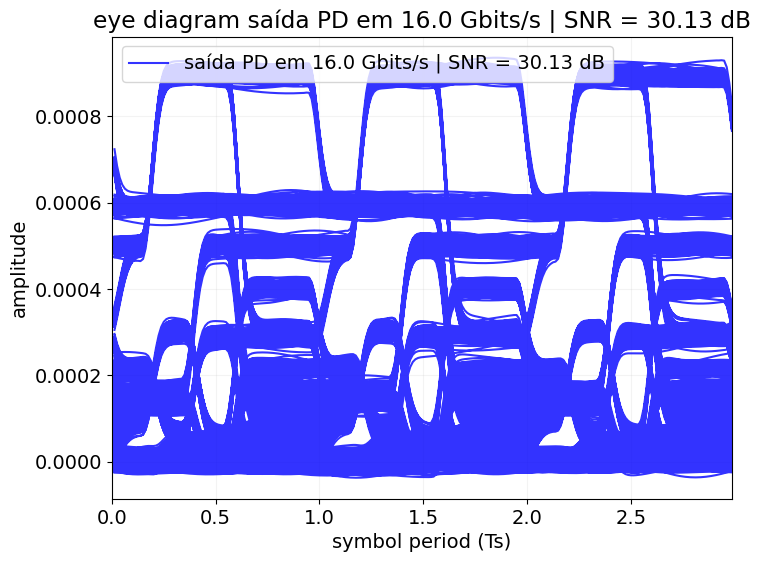

In [307]:
sigPow = inter.getresultdata('Signal_Power','total power') # signal in dBm
noisePow = inter.getresultdata('Noise_Power','total power') # noise in dBm
measuredSNR = sigPow - noisePow
bitrate = PNNPSO.getAttributes("bitrate")[0]
print(f'Measured SNR = {measuredSNR} dB')

# VSASer = inter.getresultdata('EYE_1','measurement/SER')
# print(f'VSA SER = {VSASer}')

cutMargin = 8
samplespBit = int(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('OSC_3','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

plt.rc('font', size=14) 
fig = eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=2, ptype='fast', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | SNR = {np.round(measuredSNR,2)} dB')

datapath = '../../../data/Media/PNN_Results/ParallelModel/16Gbps'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
fig.get_figure().savefig(datapath+"/"+"Article_XOR_EYE_GaussianNoise_SNR_"+str(np.round(measuredSNR,1)) + "dB.png", transparent=False, facecolor="white", bbox_inches="tight")

eyediagramFix(OSCPower, len(OSCPower), samplespBit, n=3, ptype='fast', plotlabel=f'saída PD em {bitrate*1e-9} Gbits/s | SNR = {np.round(measuredSNR,2)} dB')

#### Sampling and calculating BER

In [314]:
cutMargin = 8
samplespBit = int(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

OSCData = inter.getresult('OSC_3','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit]
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit]

LGCAData = inter.getresult('LGCA_4','digital signal')
LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2],samplespBit)
LGCAtime = np.linspace(LGCAData['time'][0],LGCAData['time'][-1],len(LGCAbit))

samples per bit = 80


Min BER: 0.49557355434168393


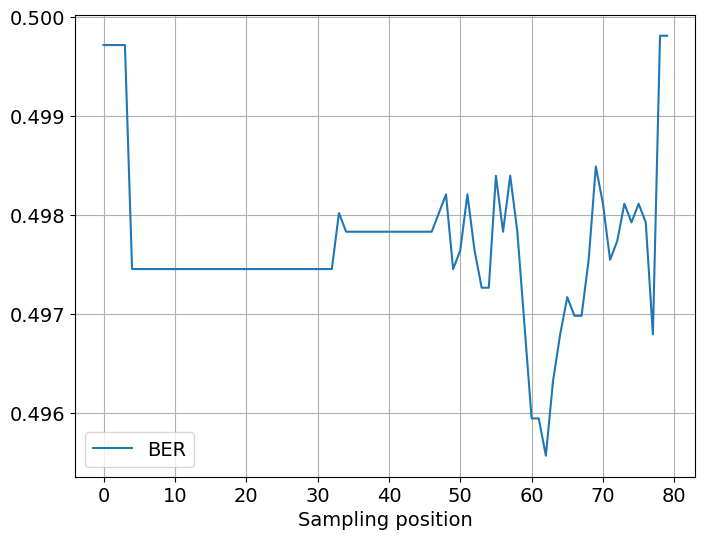

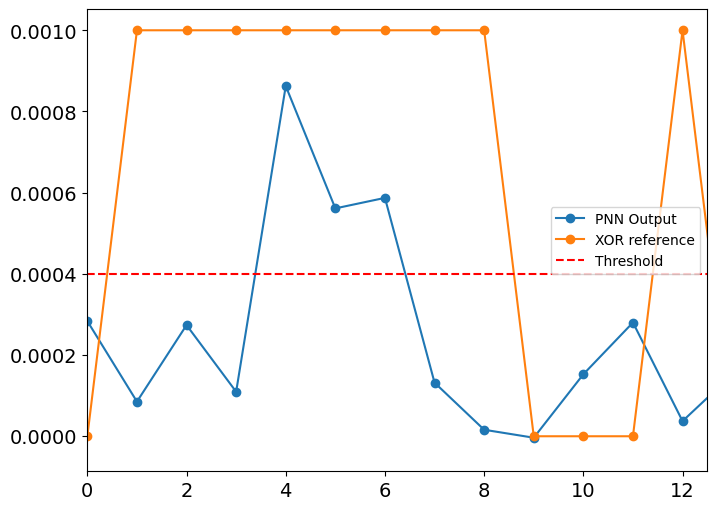

In [316]:
BERarray = np.zeros(samplespBit)

for i in range(samplespBit):
    Threshold = 0.0004
    delay = i
    sampRef = LGCAbit[corMax+delay:]
    sampOut = OSCPower[delay:]
    sampRef = sampRef[::samplespBit]
    sampOut = sampOut[::samplespBit]

    transformed = [0 if x < Threshold else 1 for x in sampOut]
    minIdx = min(len(transformed),len(sampRef))
    errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
    count = np.sum(errors==True)
    if count/minIdx > 0.5:
        BERarray[i] = 1 - count/minIdx
    else: BERarray[i] = count/minIdx

plt.figure()
plt.plot(BERarray,label='BER')
plt.xlabel('Sampling position')
plt.legend()
plt.grid()

delay = 20
sampRef = LGCAbit[corMax+delay:]
sampOut = OSCPower[delay:]

sampOut = sampOut[::samplespBit]
sampRef = sampRef[::samplespBit]
plt.figure()
plt.plot(sampOut,'-o',label='PNN Output')
plt.xlim(0,1000/samplespBit)
plt.plot(sampRef*1e-3,'-o',label='XOR reference')
plt.hlines(y=0.0004,xmin=0,xmax=100,linestyle='--',color='red',label='Threshold')
plt.legend(fontsize=10)

print(f'Min BER: {np.min(BERarray)}')

#### Optimizing Threshold and Sampling position

In [335]:
PNNPSO.output(NoisePSD=2e-21)
PNNPSO.update(inter)
inter.run()

In [339]:
cutMargin = 8  # Signal cutting. This is valid for training purposes.
ThreArray = np.linspace(0.0001,0.002,120)  # Threshold array.
sampPositions = 80  # Number of sampling positions to assume. Must be lower than samples per bit.

samplespBit = int(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')

samples per bit = 80


Threshold: 0.000164 | Min BER: 0.2782068186099077


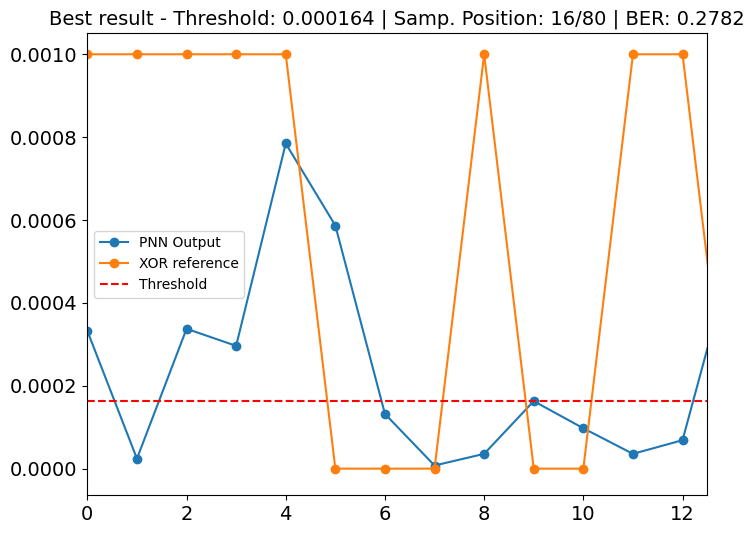

In [340]:
OSCData = inter.getresult('OSC_3','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.

LGCAData = inter.getresult('LGCA_4','digital signal')
LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2],samplespBit)
LGCAtime = np.linspace(LGCAData['time'][0],LGCAData['time'][-1],len(LGCAbit))

corMax = np.argmax(np.correlate(LGCAbit,OSCPower))

delayArray = np.floor(np.linspace(0,samplespBit-1,sampPositions)).astype(int)
BERarray = np.zeros(sampPositions)
minBERarray = np.zeros(len(ThreArray))
minBERindex = np.zeros(len(ThreArray))

for j in range(len(ThreArray)):
    Threshold = ThreArray[j]

    for i in range(sampPositions):
        sampRef = LGCAbit[corMax+delayArray[i]:]
        sampOut = OSCPower[delayArray[i]:]
        sampRef = sampRef[::samplespBit]
        sampOut = sampOut[::samplespBit]

        transformed = [0 if x < Threshold else 1 for x in sampOut]
        minIdx = min(len(transformed),len(sampRef))
        errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
        count = np.sum(errors==True)
        if count/minIdx > 0.5:
            BERarray[i] = 1 - count/minIdx
        else: BERarray[i] = count/minIdx    

    minBERarray[j] = np.min(BERarray)
    minBERindex[j] = np.argmin(BERarray)

BestThreshold = np.round(ThreArray[np.argmin(minBERarray)],6)
BestSampPos = delayArray[int(minBERindex[np.argmin(minBERarray)])]

plt.figure()
plt.title(f'Best result - Threshold: {BestThreshold} | Samp. Position: {BestSampPos}/{sampPositions} | BER: {np.round(np.min(minBERarray),4)}', fontsize=14)
plt.plot(sampOut,'-o',label='PNN Output')
plt.xlim(0,1000/samplespBit)
plt.plot(sampRef*1e-3,'-o',label='XOR reference')
plt.hlines(y=BestThreshold,xmin=0,xmax=100,linestyle='--',color='red',label='Threshold')
plt.legend(fontsize=10)
print(f'Threshold: {np.round(ThreArray[np.argmin(minBERarray)],6)} | Min BER: {np.min(minBERarray)}')

#### Cornfield Vector Example

The changing in velocity for **a single agent**, for **each iteration**, is described as follows: 

$$ v_n~=~kv_n~ ~+~ A\cdot\text{rand()} \cdot (pbest_n-n_n) ~~+~~ A\cdot\text{rand()} \cdot (gbest_n-n_n) $$ 

Where $v_n$ is the velocity value for the $n$th dimension. $\text{rand()}$ a random positive value. $pbest_n$ and $gbest_n$ are the $n$th dimension value of $pbest$ and $gbest$ positions respectively. $k$ is a inertia factor that diminishes along the simulation running to better fit results (it is an optional term). $A$ is a constant that defines the weight of $pbest_n$ and $gbest_n$ on the velocity change.

VelInit: 2.00998888969794 | PosInit: 168.1693808106176


C:\Users\Caio\AppData\Local\Temp\ipykernel_21772\674095987.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(pathFollow[0,i,0],pathFollow[1,i,0],'ro',color='black')
C:\Users\Caio\AppData\Local\Temp\ipykernel_21772\674095987.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(-300,-300,'ro',color='black',label='Partida')


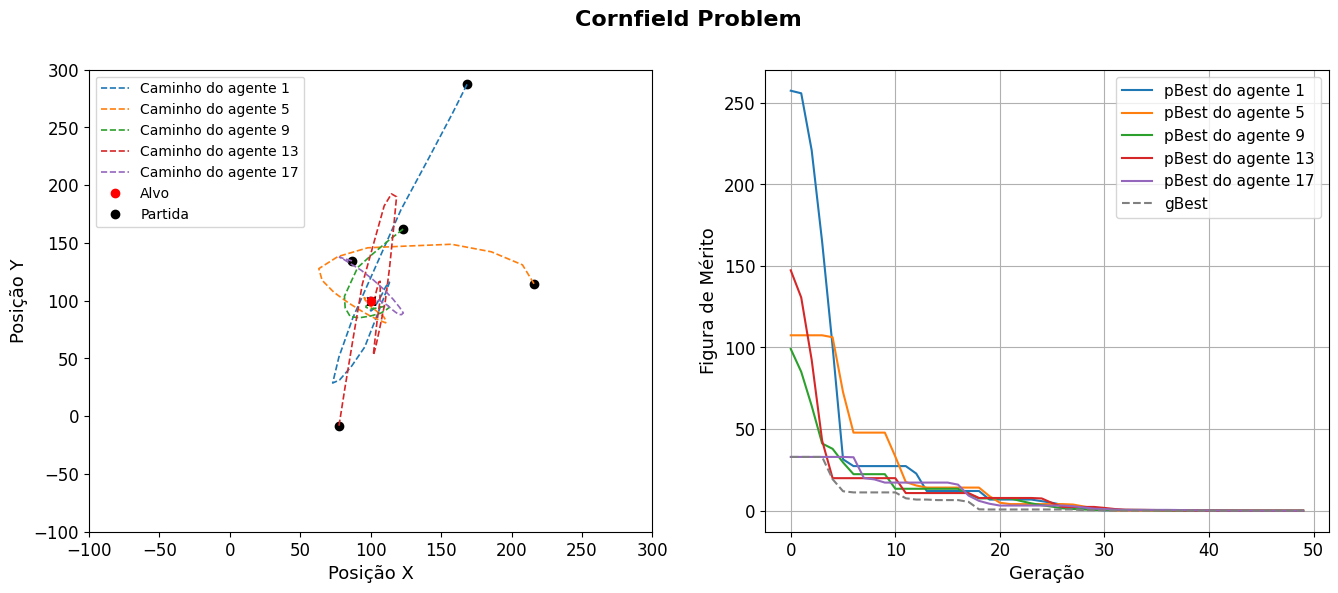

In [8]:
agents = 20  # Number of agents
gens = 50  # Max number of gens per agent
pars = 2  # Number of parameters
targetPos = [100,100]  # Target Position

def eval(currentPos,targetPos):
    evalValue = 0
    for i in range(len(currentPos)):
        evalValue += np.sqrt((currentPos[i]-targetPos[i])**2)
    return evalValue 

parArray = np.random.rand(pars,agents)*400 - 100  # Position Array (parameters)
velArray = np.random.rand(pars,agents)*40 - 20  # Velocity Array (rate of change)
pBest = np.zeros(agents)  # Personal best scores
gBest = 0  # global best score
pBestPos = np.zeros((pars,agents))  # Personal best positions
gBestPos = np.zeros(pars)  # global best position reached

# print(f'Initial Position Array: {parArray}')
# print(f'Initial Velocity Array: {velArray}')

currentEvals = np.zeros(agents)
pathFollow = np.zeros((pars,agents,gens))
pBestFollow = np.zeros((agents,gens))
gBestFollow = np.zeros(gens)

print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
for i in range(gens):
    inertia = 0.9-(i/gens)*0.5

    for j in range(agents):

        currentEvals[j] = eval(parArray[:,j],targetPos)
        if currentEvals[j] < pBest[j] or i==0: 
            pBest[j] = currentEvals[j]
            pBestPos[:,j] = parArray[:,j]
        if np.min(currentEvals) < gBest or i==0:
            gBest = np.min(currentEvals)
            gBestPos = parArray[:,np.argmin(currentEvals)]

    tilgBest = np.transpose(np.tile(gBestPos,(agents,1)))

    # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

    velArray = inertia*velArray + 2*np.random.rand()/10*(pBestPos-parArray) + 2*np.random.rand()/10*(tilgBest - parArray)
    parArray = parArray + velArray

    pathFollow[:,:,i] = parArray
    pBestFollow[:,i] = pBest
    gBestFollow[i] = gBest

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle('Cornfield Problem',fontsize=16, fontweight="bold")

for i in range(agents):
    if i%(int(agents/5))==0:
        ax[0].plot(pathFollow[0,i,0],pathFollow[1,i,0],'ro',color='black')
        ax[0].plot(pathFollow[0,i,:],pathFollow[1,i,:],linestyle='--',label=f'Caminho do agente {i+1}',linewidth=1.2)
        ax[0].plot(pathFollow[0,i,-1],pathFollow[1,i,-1],'x',color='black')
ax[0].plot(100,100,'ro',label='Alvo',linewidth=12)
ax[0].plot(-300,-300,'ro',color='black',label='Partida')
ax[0].set_xlabel('Posição X',fontsize=13)
ax[0].set_ylabel('Posição Y',fontsize=13)
ax[0].legend(fontsize=10)
ax[0].set_xlim(-100,300)
ax[0].set_ylim(-100,300)

for i in range(agents):
    if i%(int(agents/5))==0:
        ax[1].plot(np.arange(gens),pBestFollow[i,:],label=f'pBest do agente {i+1}')
ax[1].plot(np.arange(gens),gBestFollow,linestyle='--',label=f'gBest',color='gray')
ax[1].set_xlabel('Geração',fontsize=13)
ax[1].set_ylabel('Figura de Mérito',fontsize=13)
ax[1].grid()
ax[1].legend(fontsize=11)

# plt.savefig("Cornfield.pdf", format="pdf")

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Cornfield_Paths" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

#### Pyswarms version

Minimalist version

2025-05-20 13:02:36,673 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.000171
2025-05-20 13:02:36,722 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00017138134440921907, best pos: [ 99.99997507 100.00016956]
C:\Users\Caio\AppData\Local\Temp\ipykernel_12020\1835503984.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(position_history[0, i, 0], position_history[0, i, 1], 'ro', color='black')


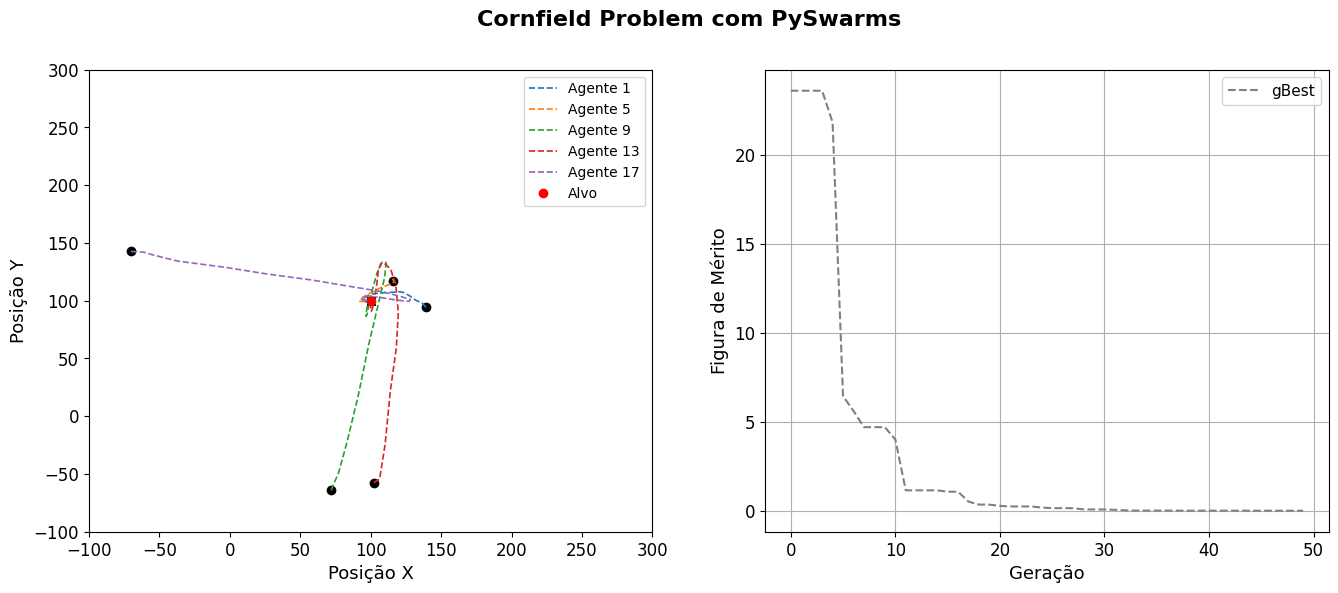

In [ ]:
agents = 20
gens = 50
pars = 2
targetPos = np.array([100, 100])

# Cost function
def objective_function(x):
    return np.linalg.norm(x - targetPos, axis=1)

# Limits
min_bounds = np.array([-100, -100])
max_bounds = np.array([300, 300])
bounds = (min_bounds, max_bounds)

# Factors
options = {'c1': 0.2, 'c2': 0.2, 'w': 0.7}

# Initialize
optimizer = ps.single.GlobalBestPSO(n_particles=agents,
                                    dimensions=pars,
                                    options=options,
                                    bounds=bounds)

cost, pos = optimizer.optimize(objective_function, iters=gens)

position_history = np.array(optimizer.pos_history)
gbest_history = optimizer.cost_history

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Cornfield Problem with PySwarms", fontsize=16, fontweight="bold")

for i in range(0, agents, int(agents/5)):
    ax[0].plot(position_history[0, i, 0], position_history[0, i, 1], 'ro', color='black')
    ax[0].plot(position_history[:, i, 0], position_history[:, i, 1], linestyle='--', label=f'Agente {i+1}', linewidth=1.2)
    ax[0].plot(position_history[-1, i, 0], position_history[-1, i, 1], 'x', color='black')

ax[0].plot(targetPos[0], targetPos[1], 'ro', label='Alvo', linewidth=12)
ax[0].set_xlabel('Posição X', fontsize=13)
ax[0].set_ylabel('Posição Y', fontsize=13)
ax[0].legend(fontsize=10)
ax[0].set_xlim(-100, 300)
ax[0].set_ylim(-100, 300)

ax[1].plot(np.arange(gens), gbest_history, linestyle='--', label='gBest', color='gray')
ax[1].set_xlabel('Geração', fontsize=13)
ax[1].set_ylabel('Figura de Mérito', fontsize=13)
ax[1].grid()
ax[1].legend(fontsize=11)

plt.show()

Backend version

C:\Users\Caio\AppData\Local\Temp\ipykernel_14944\1266646912.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(position_history[0, i, 0], position_history[0, i, 1], 'ro', color='black')


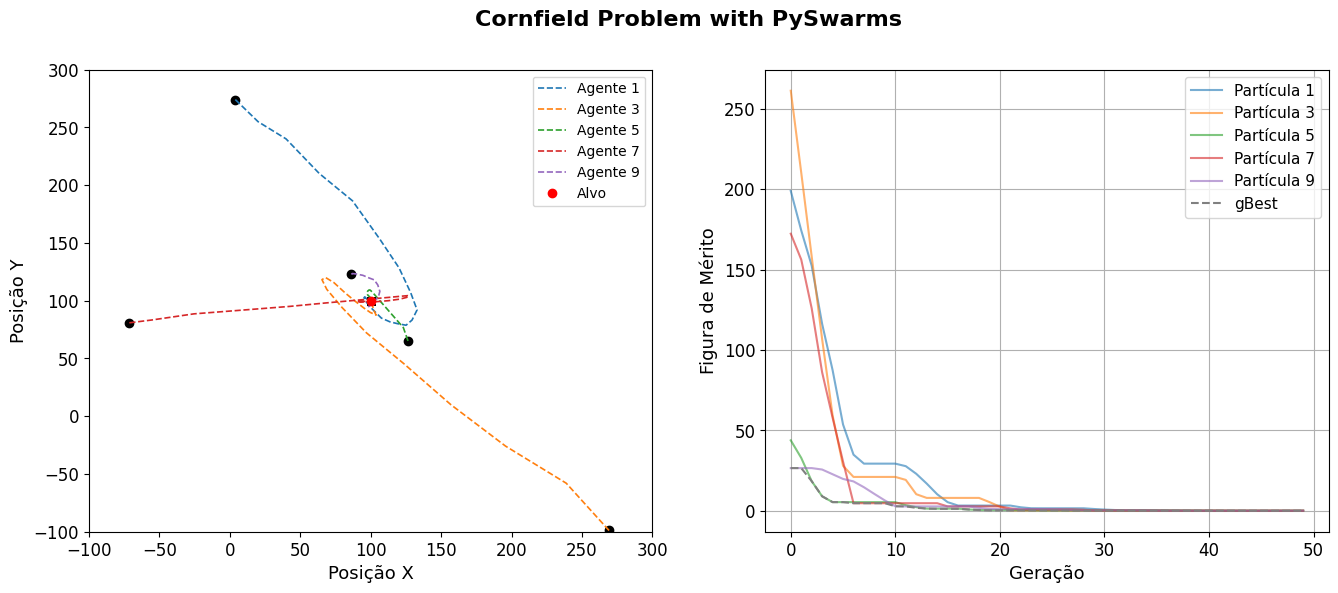

In [8]:
# Initial Configuration
agents = 10
gens = 50
pars = 2
targetPos = np.array([100, 100])

def objective_function(x):                         # Calculates the distance between the current position and target position 
    return np.linalg.norm(x - targetPos,axis=1)    # To calculate each pair individually, axis=1 is defined

# Bounds and options config
min_bounds = np.array([-100, -100])
max_bounds = np.array([300, 300])
bounds = (min_bounds, max_bounds)
options = {'c1': 0.2, 'c2': 0.2, 'w': 0.7}  # c1: pbest factor ; c2: gbest factor ; w: inertia factor

# Optimizer Initialization
optimizer = GlobalBestPSO(n_particles=agents,
                          dimensions=pars,
                          options=options,
                          bounds=bounds)
optimizer.reset()
swarm = optimizer.swarm
swarm.options = options

# Handlers for out-of-bounds agents
vh = VelocityHandler(strategy="unmodified")      # Handler for velocity
bh = BoundaryHandler(strategy="reflective")      # Handler for position

# Initialization
init_cost = compute_objective_function(swarm,objective_function)   # Initial cost of all agents

swarm.current_cost = init_cost.copy()         
swarm.pbest_cost = init_cost.copy()
swarm.pbest_pos = swarm.position.copy()           # Personal bests initialization

best_idx = np.argmin(init_cost)                   # Initial global best index
swarm.best_cost = init_cost[best_idx]             # Initial global best cost
swarm.best_pos = swarm.position[best_idx].copy()  # Initial global best position

pbest_evolution = [swarm.pbest_cost.copy()]       # pBest history array (npArray inside a list)
position_history = [swarm.position.copy()]        # Position history array (npArray inside a list)
gbest_history = [swarm.best_cost.copy()]          # gBest history array (npArray inside a list)

# Loop Optimization
for i in range(1, gens):
    swarm.velocity = compute_velocity(swarm, clamp=None, bounds=bounds, vh=vh)  # Velocity update (with general function and handlers)
    swarm.position = compute_position(swarm, bounds=bounds, bh=bh)              # Position update (with velocity and handlers)
    swarm.current_cost = compute_objective_function(swarm,objective_function)   # Current cost update

    mask = swarm.current_cost < swarm.pbest_cost                                # Mask array (using numpy)
    swarm.pbest_cost[mask] = swarm.current_cost[mask]                           # Applying mask array obtaining personal best costs
    swarm.pbest_pos[mask] = swarm.position[mask]                                # Applying mask array obtaining personal best positions

    best_idx = np.argmin(swarm.current_cost)                                    # Taking the best agent in this generation
    if swarm.current_cost[best_idx] < swarm.best_cost:                          # Verifying if the distance is lower than the best
        swarm.best_cost = swarm.current_cost[best_idx]                          # Update the best cost
        swarm.best_pos = swarm.position[best_idx].copy()                        # Update the best position

    pbest_evolution.append(swarm.pbest_cost.copy())                             # Add to pBest history
    position_history.append(swarm.position.copy())                              # Add to positions history
    gbest_history.append(swarm.best_cost.copy())                                # Add to gBest history

# Convert to numpy array
pbest_evolution = np.array(pbest_evolution)
position_history = np.array(position_history)
gbest_history = np.array(gbest_history)


# Plotting ---------------------------------------------------------------------

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Cornfield Problem with PySwarms", fontsize=16, fontweight="bold")

for i in range(0, agents, int(agents/5)):
    ax[0].plot(position_history[0, i, 0], position_history[0, i, 1], 'ro', color='black')
    ax[0].plot(position_history[:, i, 0], position_history[:, i, 1], linestyle='--', label=f'Agente {i+1}', linewidth=1.2)
    ax[0].plot(position_history[-1, i, 0], position_history[-1, i, 1], 'x', color='black')

ax[0].plot(targetPos[0], targetPos[1], 'ro', label='Alvo', linewidth=12)
ax[0].set_xlabel('Posição X', fontsize=13)
ax[0].set_ylabel('Posição Y', fontsize=13)
ax[0].legend(fontsize=10)
ax[0].set_xlim(-100, 300)
ax[0].set_ylim(-100, 300)

for i in range(0, agents, int(agents/5)):
    ax[1].plot(pbest_evolution[:, i], label=f'Partícula {i+1}', alpha=0.6)
ax[1].plot(np.arange(gens), gbest_history, linestyle='--', label='gBest', color='gray')
ax[1].set_xlabel('Geração', fontsize=13)
ax[1].set_ylabel('Figura de Mérito', fontsize=13)
ax[1].grid()
ax[1].legend(fontsize=11)

In [11]:
type(swarm.position)

numpy.ndarray

#### Comparison

VelInit: 0.03570188694286236 | PosInit: 7.7297260872653055


C:\Users\Caio\AppData\Local\Temp\ipykernel_14944\2755709028.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(position_history[0, i, 0], position_history[0, i, 1], 'ro', color='black')
C:\Users\Caio\AppData\Local\Temp\ipykernel_14944\2755709028.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(-300,-300,'ro',color='black',label='Start')
C:\Users\Caio\AppData\Local\Temp\ipykernel_14944\2755709028.py:152: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(pathFollow[0,i,0],pathFollow[1,i,0],'ro',color='black')
C:\Users\Caio\AppData\Local\Temp\ipykernel_14944\2755709028.py:156: UserWarning: color is redundantly defined by 

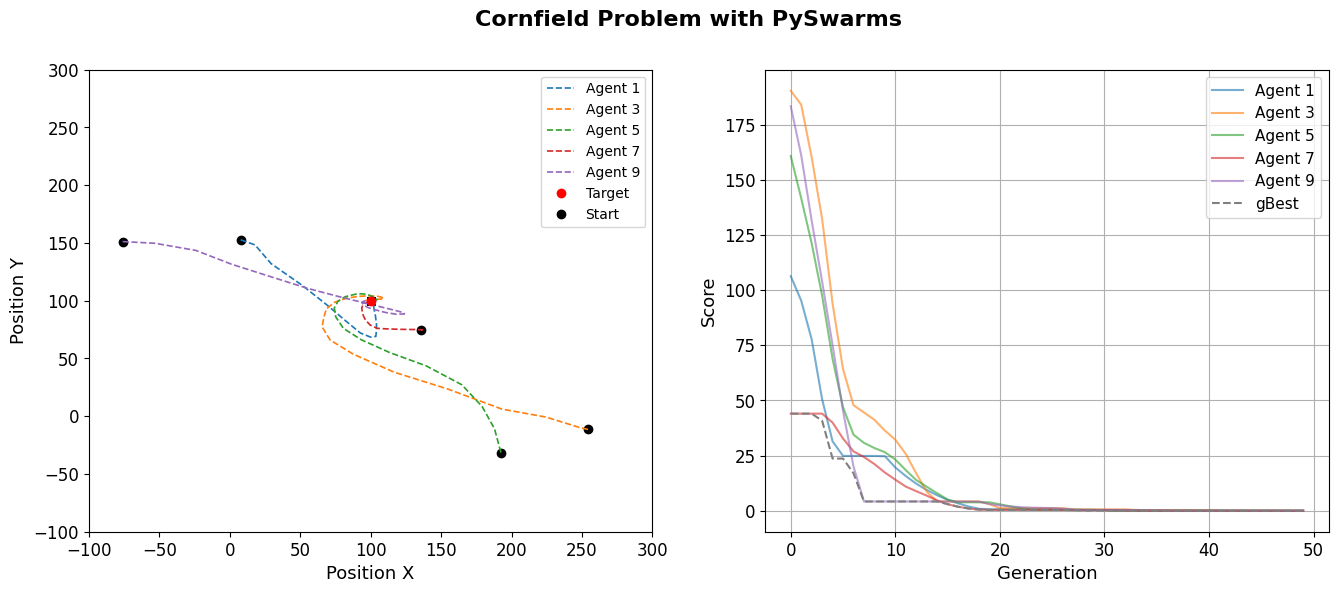

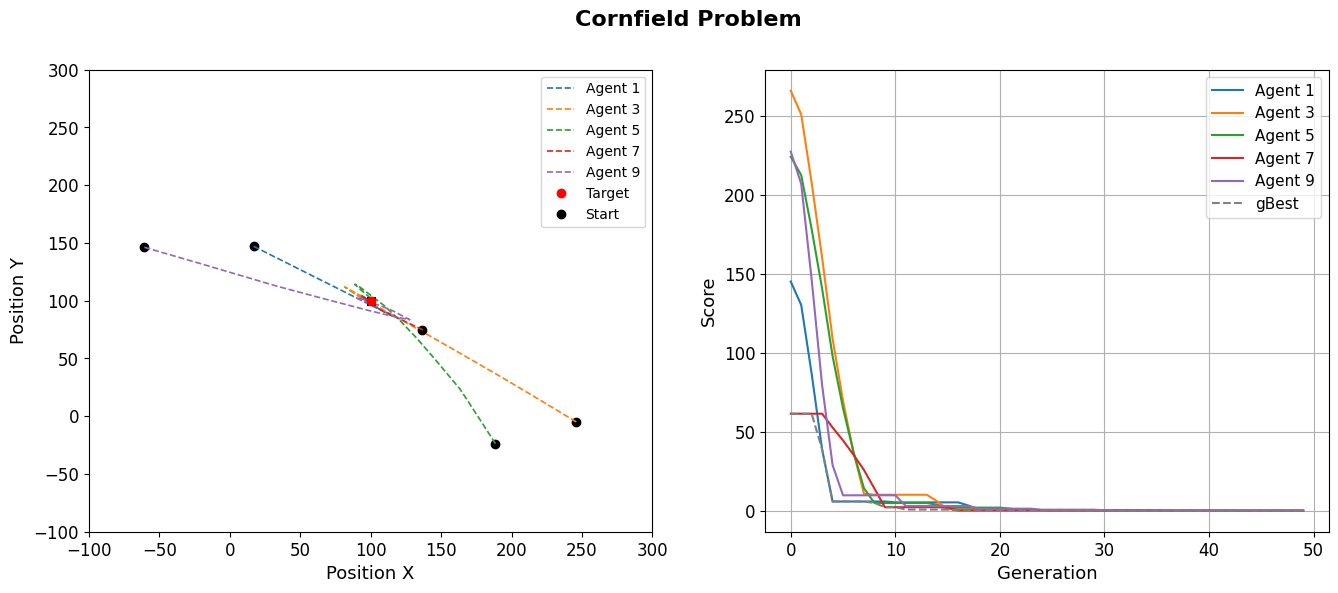

In [3]:
# Initial Configuration
agents = 10
gens = 50
pars = 2
targetPos = np.array([100, 100])

def objective_function(x):                         # Calculates the distance between the current position and target position 
    return np.linalg.norm(x - targetPos,axis=1)    # To calculate each pair individually, axis=1 is defined

# Bounds and options config
min_bounds = np.array([-100, -100])
max_bounds = np.array([300, 300])
bounds = (min_bounds, max_bounds)
options = {'c1': 0.2, 'c2': 0.2, 'w': 0.7}  # c1: pbest factor ; c2: gbest factor ; w: inertia factor

# Optimizer Initialization
optimizer = GlobalBestPSO(n_particles=agents,
                          dimensions=pars,
                          options=options,
                          bounds=bounds)
optimizer.reset()
swarm = optimizer.swarm
swarm.options = options

parArray = np.transpose(swarm.position)  # Position Array (parameters)
velArray = np.transpose(swarm.velocity)  # Velocity Array (rate of change)

# Handlers for out-of-bounds agents
vh = VelocityHandler(strategy="unmodified")      # Handler for velocity
bh = BoundaryHandler(strategy="reflective")      # Handler for position

# Initialization
init_cost = compute_objective_function(swarm,objective_function)   # Initial cost of all agents

swarm.current_cost = init_cost.copy()         
swarm.pbest_cost = init_cost.copy()
swarm.pbest_pos = swarm.position.copy()           # Personal bests initialization

pBest = init_cost.copy()

best_idx = np.argmin(init_cost)                   # Initial global best index
swarm.best_cost = init_cost[best_idx]             # Initial global best cost
swarm.best_pos = swarm.position[best_idx].copy()  # Initial global best position

gBest = init_cost[best_idx]  

pbest_evolution = [swarm.pbest_cost.copy()]       # pBest history array (npArray inside a list)
position_history = [swarm.position.copy()]        # Position history array (npArray inside a list)
gbest_history = [swarm.best_cost.copy()]          # gBest history array (npArray inside a list)

# Loop Optimization
for i in range(1, gens):
    swarm.velocity = compute_velocity(swarm, clamp=None, bounds=bounds, vh=vh)  # Velocity update (with general function and handlers)
    swarm.position = compute_position(swarm, bounds=bounds, bh=bh)              # Position update (with velocity and handlers)
    swarm.current_cost = compute_objective_function(swarm,objective_function)   # Current cost update

    mask = swarm.current_cost < swarm.pbest_cost                                # Mask array (using numpy)
    swarm.pbest_cost[mask] = swarm.current_cost[mask]                           # Applying mask array obtaining personal best costs
    swarm.pbest_pos[mask] = swarm.position[mask]                                # Applying mask array obtaining personal best positions

    best_idx = np.argmin(swarm.current_cost)                                    # Taking the best agent in this generation
    if swarm.current_cost[best_idx] < swarm.best_cost:                          # Verifying if the distance is lower than the best
        swarm.best_cost = swarm.current_cost[best_idx]                          # Update the best cost
        swarm.best_pos = swarm.position[best_idx].copy()                        # Update the best position

    pbest_evolution.append(swarm.pbest_cost.copy())                             # Add to pBest history
    position_history.append(swarm.position.copy())                              # Add to positions history
    gbest_history.append(swarm.best_cost.copy())                                # Add to gBest history

# Convert to numpy array
pbest_evolution = np.array(pbest_evolution)
position_history = np.array(position_history)
gbest_history = np.array(gbest_history)

# Plotting ---------------------------------------------------------------------

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Cornfield Problem with PySwarms", fontsize=16, fontweight="bold")

for i in range(0, agents, int(agents/5)):
    ax[0].plot(position_history[0, i, 0], position_history[0, i, 1], 'ro', color='black')
    ax[0].plot(position_history[:, i, 0], position_history[:, i, 1], linestyle='--', label=f'Agent {i+1}', linewidth=1.2)
    ax[0].plot(position_history[-1, i, 0], position_history[-1, i, 1], 'x', color='black')

ax[0].plot(targetPos[0], targetPos[1], 'ro', label='Target', linewidth=12)
ax[0].plot(-300,-300,'ro',color='black',label='Start')
ax[0].set_xlabel('Position X', fontsize=13)
ax[0].set_ylabel('Position Y', fontsize=13)
ax[0].legend(fontsize=10)
ax[0].set_xlim(-100, 300)
ax[0].set_ylim(-100, 300)

for i in range(0, agents, int(agents/5)):
    ax[1].plot(pbest_evolution[:, i], label=f'Agent {i+1}', alpha=0.6)
ax[1].plot(np.arange(gens), gbest_history, linestyle='--', label='gBest', color='gray')
ax[1].set_xlabel('Generation', fontsize=13)
ax[1].set_ylabel('Score', fontsize=13)
ax[1].grid()
ax[1].legend(fontsize=11)


# Autoral code ---------------------------------------------------------------

def eval(currentPos,targetPos):
    evalValue = 0
    for i in range(len(currentPos)):
        evalValue += np.sqrt((currentPos[i]-targetPos[i])**2)
    return evalValue 

pBestPos = np.zeros((pars,agents))  # Personal best positions
gBestPos = np.zeros(pars)  # global best position reached

# print(f'Initial Position Array: {parArray}')
# print(f'Initial Velocity Array: {velArray}')

currentEvals = np.zeros(agents)
pathFollow = np.zeros((pars,agents,gens))
pBestFollow = np.zeros((agents,gens))
gBestFollow = np.zeros(gens)

print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
for i in range(gens):
    # inertia = 0.7-(i/gens)*0.5
    inertia = 0.7

    for j in range(agents):

        currentEvals[j] = eval(parArray[:,j],targetPos)
        if currentEvals[j] < pBest[j] or i==0: 
            pBest[j] = currentEvals[j]
            pBestPos[:,j] = parArray[:,j]
        if np.min(currentEvals) < gBest or i==0:
            gBest = np.min(currentEvals)
            gBestPos = parArray[:,np.argmin(currentEvals)]

    tilgBest = np.transpose(np.tile(gBestPos,(agents,1)))

    # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

    velArray = inertia*velArray + 2*np.random.rand()/10*(pBestPos-parArray) + 2*np.random.rand()/10*(tilgBest - parArray)
    parArray = parArray + velArray

    pathFollow[:,:,i] = parArray
    pBestFollow[:,i] = pBest
    gBestFollow[i] = gBest

figure,ax=plt.subplots(1, 2,figsize=(16,6))
figure.suptitle('Cornfield Problem',fontsize=16, fontweight="bold")

for i in range(agents):
    if i%(int(agents/5))==0:
        ax[0].plot(pathFollow[0,i,0],pathFollow[1,i,0],'ro',color='black')
        ax[0].plot(pathFollow[0,i,:],pathFollow[1,i,:],linestyle='--',label=f'Agent {i+1}',linewidth=1.2)
        ax[0].plot(pathFollow[0,i,-1],pathFollow[1,i,-1],'x',color='black')
ax[0].plot(100,100,'ro',label='Target',linewidth=12)
ax[0].plot(-300,-300,'ro',color='black',label='Start')
ax[0].set_xlabel('Position X',fontsize=13)
ax[0].set_ylabel('Position Y',fontsize=13)
ax[0].legend(fontsize=10)
ax[0].set_xlim(-100,300)
ax[0].set_ylim(-100,300)

for i in range(agents):
    if i%(int(agents/5))==0:
        ax[1].plot(np.arange(gens),pBestFollow[i,:],label=f'Agent {i+1}')
ax[1].plot(np.arange(gens),gBestFollow,linestyle='--',label=f'gBest',color='gray')
ax[1].set_xlabel('Generation',fontsize=13)
ax[1].set_ylabel('Score',fontsize=13)
ax[1].grid()
ax[1].legend(fontsize=11)

In [211]:
parArray

array([[169.5250205 ,  63.36534281],
       [282.15349395,  74.72734101],
       [ -6.61783793, 229.21126457],
       [143.68508883, 172.98022167],
       [226.24352416, 285.63923189],
       [ 38.55249269, -23.99711477],
       [ 13.71943557, 125.01689343],
       [-70.92859894, 184.81318665],
       [ 90.29133833, 181.69225746],
       [235.61748218,  92.29444203]])

#### Appyling the algorithm

In [347]:
samplespBit = 20  # Choosing Samples per bit
numberOfBits = 32768*1/2 # Choosing number of bits

# Choosing "Samples per Bit" and "Number of Bits" prior the "time window" and "number of samples" 
# avoid decimals and hence, avoid errors regarding different array sizes on simulations wiht large number of samples.

PNNPSO.output(NoisePSD=2e-21)
PNNPSO.simulation(bitrate=16e9,numofSamples=samplespBit*numberOfBits)
timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*samplespBit)
PNNPSO.simulation(timeWindow=timeWindow)
PNNPSO.update(inter)

print(f'number of samples = {PNNPSO.getAttributes("numofSamples")[0]}')
print(f'samples per bit = {samplespBit}')
print(f'time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns')
print(f'bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

cutMargin = 8  # Signal cutting. This is valid for training purposes.
sampPositions = samplespBit  # Number of sampling positions to assume. Must be lower than samples per bit.

agents = 4  # Number of agents
gens = 5  # Max number of gens per agent
pars = 3  # Number of parameters

number of samples = 327680.0
samples per bit = 20
time Window = 1024.0 ns
bits = 16384.0


  0%|          | 0/20 [00:00<?, ?it/s]

VelInit: 0.3452772251195624 | PosInit: 3.0312283270374873


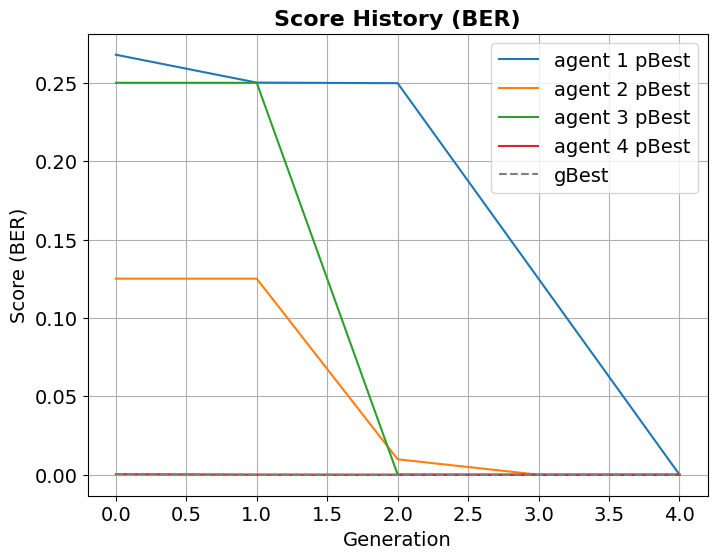

In [ ]:
parArray = np.random.rand(pars,agents)*1.5*np.pi + 0.25*np.pi  # Position Array (parameters - phases)
velArray = np.random.rand(pars,agents)/2  # Velocity Array (rate of change)
pBest = np.zeros(agents)  # Personal best scores (Smaller BER)
gBest = 0  # global best score (Smaller BER)
pBestPos = np.zeros((pars,agents))  # Personal best positions
gBestPos = np.zeros(pars)  # global best position reached

# print(f'Initial Position Array: {parArray}')
# print(f'Initial Velocity Array: {velArray}')

progress = tqdm(total= gens*agents)

currentEvals = np.zeros(agents)
pathFollow = np.zeros((pars,agents,gens))
pBestFollow = np.zeros((agents,gens))
gBestFollow = np.zeros(gens)

print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
for i in range(gens):
    inertia = 0.9-(i/gens)*0.5

    for j in range(agents):
        # Simulation Section ---------------------------------------------------------
        inter.switchtolayout()
        inter.setnamed('IDEAL_CELL_5','Common Theta',parArray[0,j])
        inter.setnamed('IDEAL_CELL_6','Common Theta',parArray[1,j])
        inter.setnamed('IDEAL_CELL_7','Common Theta',parArray[2,j])
        inter.run()

        OSCData = inter.getresult('OSC_3','signal')
        Datakeys = list(OSCData.keys())
        OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.
        OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.

        LGCAData = inter.getresult('LGCA_4','digital signal')
        LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2],samplespBit)
        LGCAtime = np.linspace(LGCAData['time'][0],LGCAData['time'][-1],len(LGCAbit))

        corMax = np.argmax(np.correlate(LGCAbit,OSCPower))

        delayArray = np.floor(np.linspace(0,samplespBit-1,sampPositions)).astype(int)
        BERarray = np.zeros(sampPositions)
        minBERarray = np.zeros(len(ThreArray))
        minBERindex = np.zeros(len(ThreArray))

        for k in range(len(ThreArray)):
            Threshold = ThreArray[k]

            for m in range(sampPositions):
                sampRef = LGCAbit[corMax+delayArray[m]:]
                sampOut = OSCPower[delayArray[m]:]
                sampRef = sampRef[::samplespBit]
                sampOut = sampOut[::samplespBit]

                transformed = [0 if x < Threshold else 1 for x in sampOut]
                minIdx = min(len(transformed),len(sampRef))
                errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
                count = np.sum(errors==True)
                if count/minIdx > 0.5:
                    BERarray[m] = 1 - count/minIdx
                else: BERarray[m] = count/minIdx    

            minBERarray[k] = np.min(BERarray)
            minBERindex[k] = np.argmin(BERarray)

        progress.update(1)
    
        # PSO Section ---------------------------------------------------------
        currentEvals[j] = np.min(minBERarray)
        if currentEvals[j] < pBest[j] or i==0: 
            pBest[j] = currentEvals[j]
            pBestPos[:,j] = parArray[:,j]
        if np.min(currentEvals) < gBest or i==0:
            gBest = np.min(currentEvals)
            gBestPos = parArray[:,np.argmin(currentEvals)]

    tilgBest = np.transpose(np.tile(gBestPos,(agents,1)))

    # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

    velArray = inertia*velArray + 2*np.random.rand()/5*(pBestPos-parArray) + 2*np.random.rand()/5*(tilgBest - parArray)
    parArray = parArray + velArray

    pathFollow[:,:,i] = parArray
    pBestFollow[:,i] = pBest
    gBestFollow[i] = gBest

plt.figure()
plt.title('Score History (BER)',fontsize=16, fontweight="bold")

for i in range(agents):
    # if i%(int(agents/4))==0:
    plt.plot(np.arange(gens),pBestFollow[i,:],label=f'agent {i+1} pBest')
plt.plot(np.arange(gens),gBestFollow,linestyle='--',label=f'gBest',color='gray')
plt.xlabel('Generation')
plt.ylabel('Score (BER)')
plt.grid()
plt.legend()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm/16Gbps'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"XOR_Particle_Swarm (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")

#### Time plot of sampling and threshold

Threshold: 7.63e-05 | Min BER: 0.1251763378162325


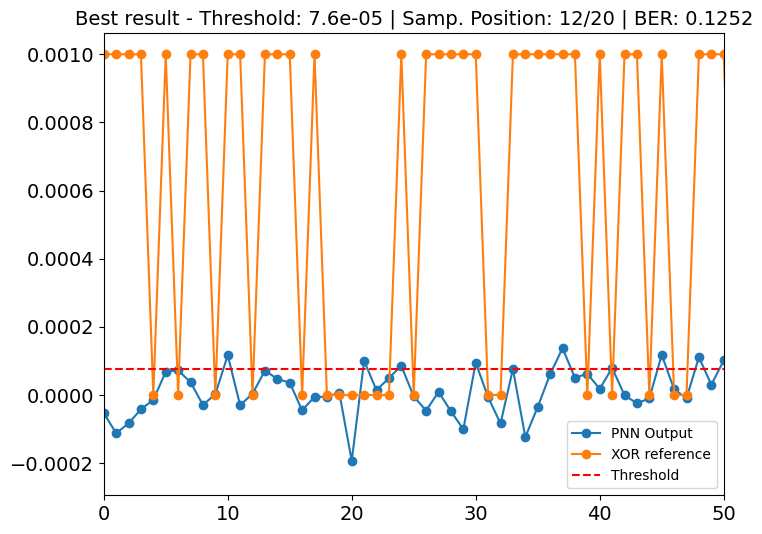

In [68]:
inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Common Theta',gBestPos[0])
inter.setnamed('IDEAL_CELL_6','Common Theta',gBestPos[1])
inter.setnamed('IDEAL_CELL_7','Common Theta',gBestPos[2])
inter.run()

OSCData = inter.getresult('OSC_3','signal')
Datakeys = list(OSCData.keys())
OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.
OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.

ThreArray = np.linspace(np.max(OSCPower),(np.min(OSCPower)>0)*np.min(OSCPower),60)  # Threshold array.

LGCAData = inter.getresult('LGCA_4','digital signal')
LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2],samplespBit) # in Interconnect, Each 2 samples are related to one bit

corMax = np.argmax(np.correlate(LGCAbit,OSCPower))

delayArray = np.floor(np.linspace(0,samplespBit-1,sampPositions)).astype(int)
BERarray = np.zeros(sampPositions)
minBERarray = np.zeros(len(ThreArray))
minBERindex = np.zeros(len(ThreArray))

for k in range(len(ThreArray)):
    Threshold = ThreArray[k]

    for m in range(sampPositions):
        sampRef = LGCAbit[corMax+delayArray[m]:]
        sampOut = OSCPower[delayArray[m]:]
        sampRef = sampRef[::samplespBit]
        sampOut = sampOut[::samplespBit]

        transformed = [0 if x < Threshold else 1 for x in sampOut]
        minIdx = min(len(transformed),len(sampRef))
        errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
        count = np.sum(errors==True)
        if count/minIdx > 0.5:
            BERarray[m] = 1 - count/minIdx
        else: BERarray[m] = count/minIdx    

    minBERarray[k] = np.min(BERarray)
    minBERindex[k] = np.argmin(BERarray)

BestThreshold = np.round(ThreArray[np.argmin(minBERarray)],6)
BestSampPos = delayArray[int(minBERindex[np.argmin(minBERarray)])]

plt.figure()
plt.title(f'Best result - Threshold: {np.round(BestThreshold,6)} | Samp. Position: {BestSampPos}/{samplespBit} | BER: {np.round(np.min(minBERarray),4)}', fontsize=14)
plt.plot(sampOut,'-o',label='PNN Output')
plt.xlim(0,1000/samplespBit)
plt.plot(sampRef*1e-3,'-o',label='XOR reference')
plt.hlines(y=BestThreshold,xmin=0,xmax=100,linestyle='--',color='red',label='Threshold')
plt.legend(fontsize=10)
print(f'Threshold: {np.round(ThreArray[np.argmin(minBERarray)],7)} | Min BER: {np.min(minBERarray)}')

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"XOR_Particle_Swarm_Result (" + str(file_count) + ").png", transparent=False, facecolor="white", bbox_inches="tight")

Threshold: 0.0001 | Min BER: 0.13994169096209913


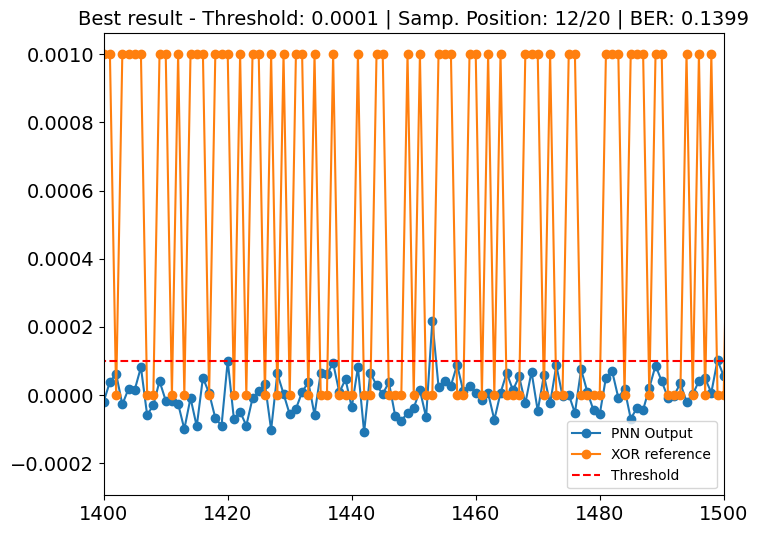

In [60]:
plt.figure()
plt.title(f'Best result - Threshold: {BestThreshold} | Samp. Position: {BestSampPos}/{samplespBit} | BER: {np.round(np.min(minBERarray),4)}', fontsize=14)
plt.plot(sampOut,'-o',label='PNN Output')
plt.xlim(1400,1500)
plt.plot(sampRef*1e-3,'-o',label='XOR reference')
plt.hlines(y=BestThreshold,xmin=0,xmax=10000,linestyle='--',color='red',label='Threshold')
plt.legend(fontsize=10)
print(f'Threshold: {np.round(ThreArray[np.argmin(minBERarray)],7)} | Min BER: {np.min(minBERarray)}')

### Optical Filter Changing

In [44]:
PNNPSO = PNN(DelayUnitLen=811e-6,unitsNextTap=4,WvgLoss=591.86)
PNNPSO.transmission(FiberLen=10e3,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1,ToggleBitOp=True)
PNNPSO.simulation(bitrate=16e9,timeWindow=5.12e-9*128/16,numofSamples=65536/4 * 32/25)
PNNPSO.output(OutputType='mixed',ToggleAWGN=False,ToggleOptFilter=True)
PNNPSO.photoreceptor(PDResponsivity=0.9,PDDarkCurrent=50e-9,TogglePDSNoise=True)
PNNPSO.showParameters()

print(f'Number of Bits = {PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]}')
print(f'Samples per Bits = {(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))}')

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 4 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 10.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 16.0 Gbits/s | Number of Samples: 20971.52 | Time Window: 4.096e-08 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: enabled
AWGN post PD: disabled
Optical Filter: enabled
Output Type: mixed
Number of Bits = 655.36
Samples per Bits = 32.0


In [45]:
PNNPSO.mount(inter)

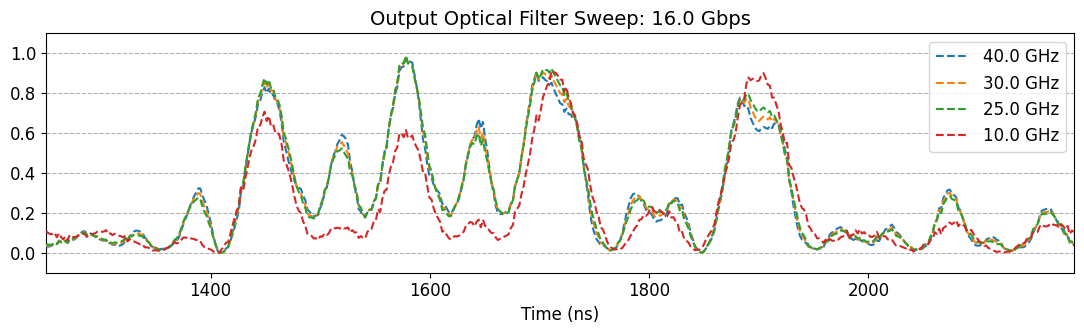

In [46]:
# Initial simulation config
OptimalWeights = [0.91940,0.30309,4.20008]
samplespBit = int(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))
cutMargin = 8

inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5', 'Common Theta', OptimalWeights[0])
inter.setnamed('IDEAL_CELL_6', 'Common Theta', OptimalWeights[1])
inter.setnamed('IDEAL_CELL_7', 'Common Theta', OptimalWeights[2])

plt.figure(figsize=(11,3.5))

FilterBandArray = [40e9,30e9,25e9,10e9]

for i in range(len(FilterBandArray)):

    inter.switchtolayout()
    inter.setnamed('Optical Filter','bandwidth',FilterBandArray[i])
    inter.run()

    OSCData = inter.getresult('OSC_2', 'signal')
    OSCTime = OSCData['time'][cutMargin * samplespBit:-cutMargin * samplespBit][:, 0]
    OSCPower = OSCData['amplitude (a.u.)'][cutMargin * samplespBit:-cutMargin * samplespBit]

    bitrate = PNNPSO.getAttributes("bitrate")[0]
    maxvalue = np.max(OSCPower)
    OSCPower = OSCPower / maxvalue

    plt.plot(OSCTime * 1e12, OSCPower, linestyle='--', zorder=3,linewidth=1.5, label=f'{np.round(FilterBandArray[i]*1e-9,2)} GHz')

plt.xlim(20e12 / bitrate ,35e12 / bitrate)
plt.ylim([-0.1, 1.1])
plt.grid(True, linestyle='--', axis='y', zorder=1)
plt.xlabel('Time (ns)', fontsize=12)
plt.title(f'Output Optical Filter Sweep: {bitrate*1e-9} Gbps', fontsize=14)
plt.legend()

plt.tight_layout()

# plt.savefig('TimeTrace_Filter.pdf', format='pdf', bbox_inches='tight')

plt.show()

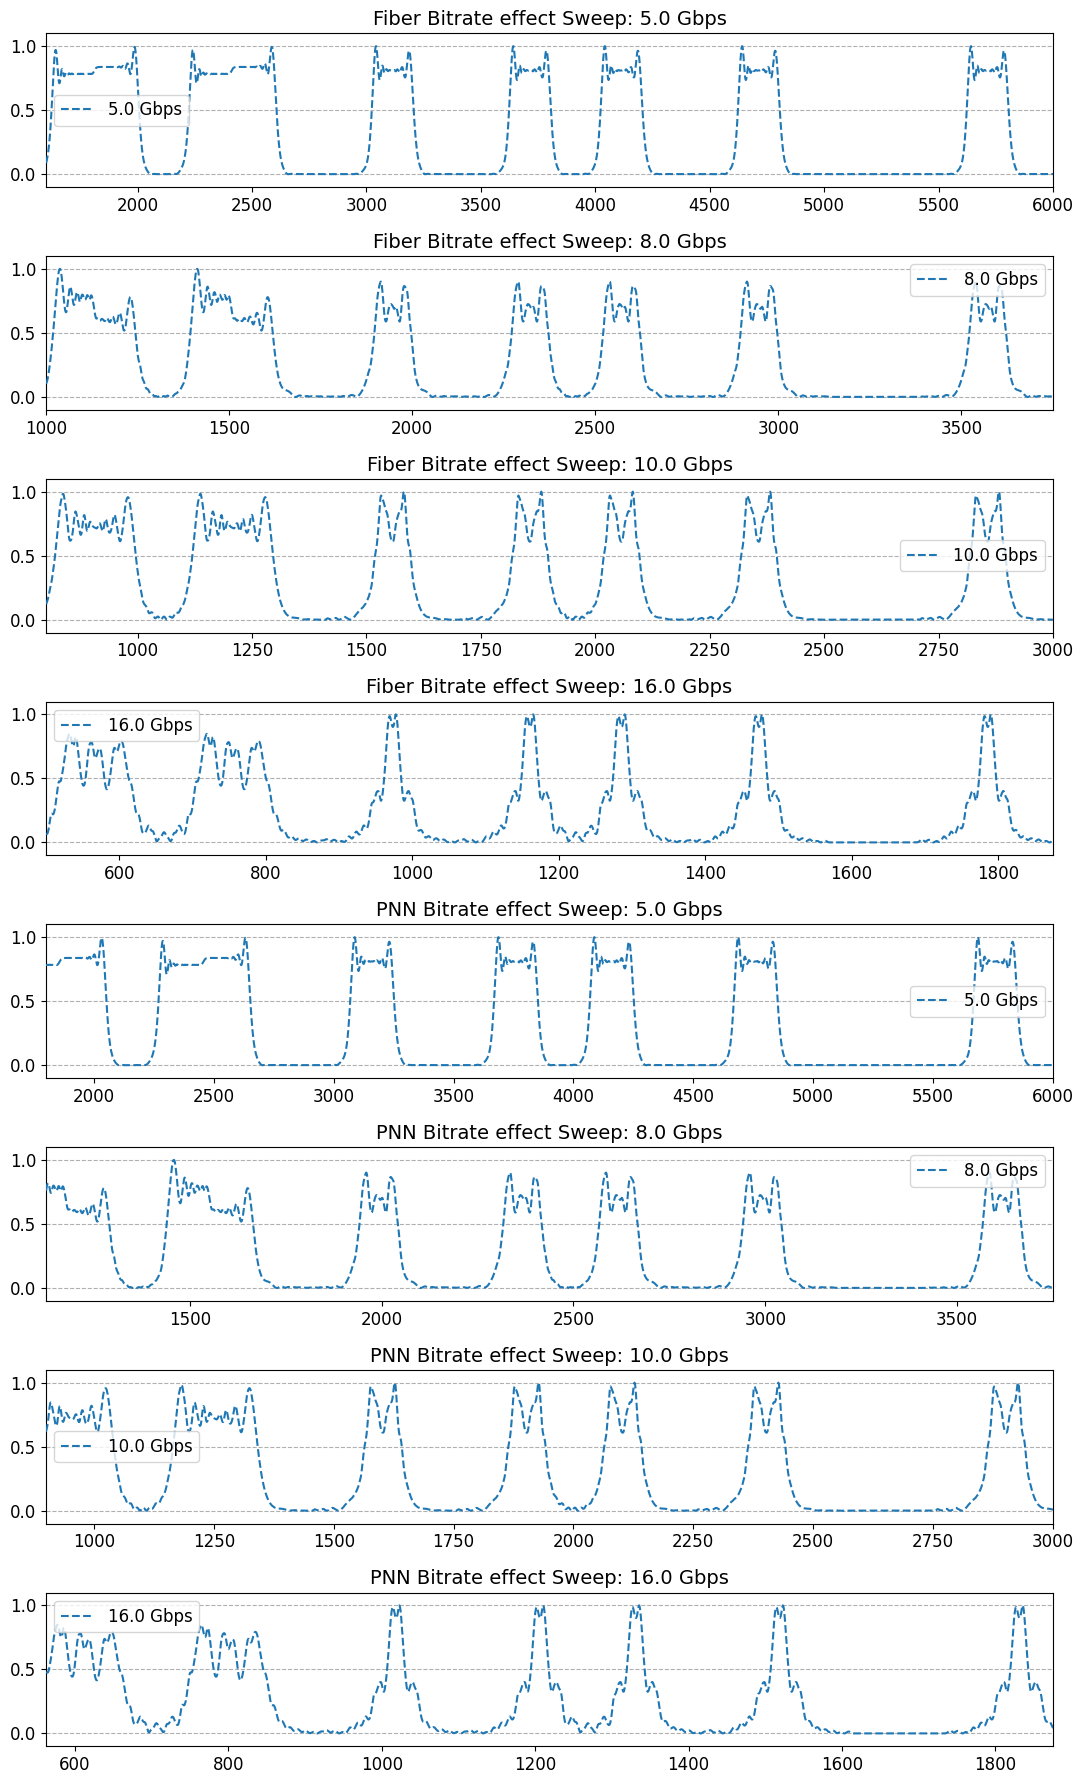

In [60]:
BitrateArray = [5e9,8e9,10e9,16e9]

# Initial simulation config
OptimalWeights = [0.91940,0.30309,4.20008]
cutMargin = 8

inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5', 'Common Theta', OptimalWeights[0])
inter.setnamed('IDEAL_CELL_6', 'Common Theta', OptimalWeights[1])
inter.setnamed('IDEAL_CELL_7', 'Common Theta', OptimalWeights[2])

fig, ax = plt.subplots(8, 1, figsize=(11, 18), sharex=False)

for i in range(len(BitrateArray)):

    PNNPSO.simulation(bitrate=BitrateArray[i], timeWindow=5.12e-9*32/(BitrateArray[i]*1e-9))
    PNNPSO.update(inter)
    samplespBit = int(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))

    inter.run()

    OSCData = inter.getresult('OOSC_1', 'sum/signal')
    OSCTime = OSCData['time'][cutMargin * samplespBit:-cutMargin * samplespBit][:, 0]
    OSCPower = OSCData['power (W) at 193.1e+012 Hz'][cutMargin * samplespBit:-cutMargin * samplespBit]

    bitrate = PNNPSO.getAttributes("bitrate")[0]
    maxvalue = np.max(OSCPower)
    OSCPower = OSCPower / maxvalue

    ax[i].plot(OSCTime * 1e12, OSCPower, linestyle='--', zorder=3,linewidth=1.5, label=f'{np.round(BitrateArray[i]*1e-9,2)} Gbps')
    ax[i].set_xlim(8e12 / BitrateArray[i] ,30e12 / BitrateArray[i])
    ax[i].set_ylim([-0.1, 1.1])
    ax[i].grid(True, linestyle='--', axis='y', zorder=1)
    # ax[i].set_xlabel('Time (ns)', fontsize=12)
    ax[i].set_title(f'Fiber Bitrate effect Sweep: {BitrateArray[i]*1e-9} Gbps', fontsize=14)
    ax[i].legend()

    OSCData = inter.getresult('arm1_osc', 'signal')
    OSCTime = OSCData['time'][cutMargin * samplespBit:-cutMargin * samplespBit][:, 0]
    OSCPower = OSCData['amplitude (a.u.)'][cutMargin * samplespBit:-cutMargin * samplespBit]

    bitrate = PNNPSO.getAttributes("bitrate")[0]
    maxvalue = np.max(OSCPower)
    OSCPower = OSCPower / maxvalue

    ax[i+4].plot(OSCTime * 1e12, OSCPower, linestyle='--', zorder=3,linewidth=1.5, label=f'{np.round(BitrateArray[i]*1e-9,2)} Gbps')
    ax[i+4].set_xlim(9e12 / BitrateArray[i] ,30e12 / BitrateArray[i])
    ax[i+4].set_ylim([-0.1, 1.1])
    ax[i+4].grid(True, linestyle='--', axis='y', zorder=1)
    # ax[i].set_xlabel('Time (ns)', fontsize=12)
    ax[i+4].set_title(f'PNN Bitrate effect Sweep: {BitrateArray[i]*1e-9} Gbps', fontsize=14)
    ax[i+4].legend()

plt.tight_layout()

# plt.savefig('TimeTrace_Filter.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [49]:
OSCData.keys()

dict_keys(['time', 'power (W) at 193.1e+012 Hz', 'Lumerical_dataset'])

## Mount PNN | Series

In [85]:
display(Math('For~No~Loss:~K1=0.75~~~K2=0.666~~~K3=0.5'))

<IPython.core.display.Math object>

In [176]:
DelayDL = 1 # Delta L in delay lines (given in BULs)
BULLength = 811e-6 # Length of one BUL (m)

inter.switchtolayout()
inter.deleteall()

SeriesPNN(inter,DelayDL,BULLength)

1.0

In [162]:
inter.run()

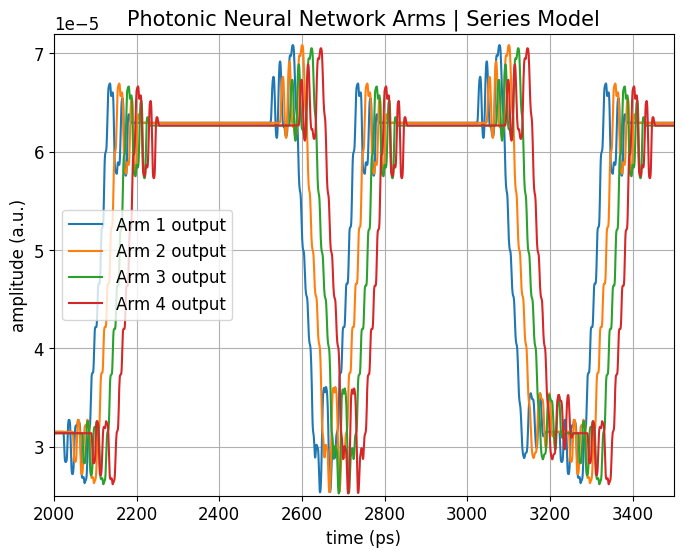

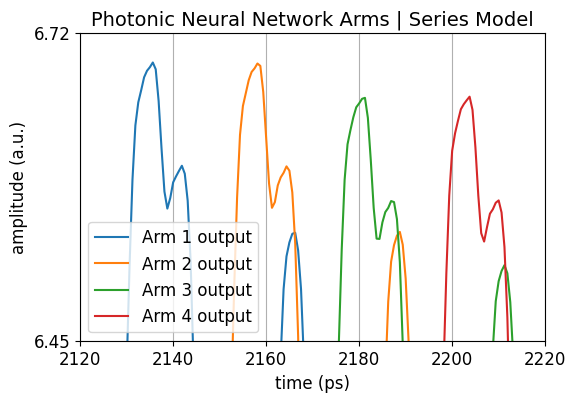

In [169]:
Osci_Out1 = inter.getresult('OSC_2','signal')['amplitude (a.u.)']
Osci_Out2 = inter.getresult('OSC_3','signal')['amplitude (a.u.)']
Osci_Out3 = inter.getresult('OSC_4','signal')['amplitude (a.u.)']
Osci_Out4 = inter.getresult('OSC_5','signal')['amplitude (a.u.)']
Osci_time = inter.getresult('OSC_2','signal')['time']

plt.figure(figsize=(8,6))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.plot(Osci_time*1e12,Osci_Out3,label='Arm 3 output')
plt.plot(Osci_time*1e12,Osci_Out4,label='Arm 4 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network Arms | Series Model',fontsize=15)
plt.ylim(2.5e-5,7.2e-5)
plt.xlim(2000,3500)
plt.legend()
plt.grid()

plt.figure(figsize=(6,4))
plt.plot(Osci_time*1e12,Osci_Out1,label='Arm 1 output')
plt.plot(Osci_time*1e12,Osci_Out2,label='Arm 2 output')
plt.plot(Osci_time*1e12,Osci_Out3,label='Arm 3 output')
plt.plot(Osci_time*1e12,Osci_Out4,label='Arm 4 output')
plt.xlabel('time (ps)',fontsize=12)
plt.ylabel('amplitude (a.u.)',fontsize=12)
plt.title('Photonic Neural Network Arms | Series Model',fontsize=14)
plt.xlim(2120,2220)
plt.ylim(6.45e-5,6.72e-5)
dyArray = {'6.45':6.45e-5 , '6.72':6.72e-5}
plt.yticks(list(dyArray.values()), labels=dyArray.keys())
plt.legend()
plt.grid()